In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from catboost import CatBoostClassifier
from catboost import Pool

In [3]:
# read data
train = pd.read_csv('./data/train.csv',index_col='id')
test = pd.read_csv('./data/test.csv',index_col='id')

In [4]:
test_pool = Pool(test, feature_names= test.columns.tolist())

In [11]:
X_train, X_val, y_train, y_val = train_test_split(train.drop('target', axis = 1), train.target, test_size=0.33, random_state=42)

train_pool = Pool(X_train, y_train, feature_names=X_train.columns.tolist())
val_pool   = Pool(X_val, y_val, feature_names=X_val.columns.tolist())

catModel = CatBoostClassifier(verbose=True, iterations=1000, thread_count=4, random_seed=42,
                              use_best_model= True, od_type = 'Iter', od_wait = 20)

catModel.fit(train_pool, eval_set=val_pool, use_best_model = True)

In [4]:
params = {'depth': 7, 'rate': 0.03, 'l2': 3, 'T': 1}

In [3]:
def submit(pred, fName = 'submission.csv'):
    ## make submission file
    df = pd.DataFrame(pred,columns=['target'],index=test.index)
    df.to_csv(fName,index_label='id')

In [7]:
def gini(actual, pred, cmpcol = 0, sortcol = 1):
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses
    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)
 
def gini_normalized(a, p):
    return gini(a, p) / gini(a, a)

class GiniMetric(object):
    def get_final_error(self, error, weight):
        return error

    def is_max_optimal(self):
        return True

    def evaluate(self, approxes, target, weight):
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])

        t = np.array(target)
        a = np.array(approxes[0])
        
        error_sum  = gini_normalized(t, a)

        return error_sum, 1.0

In [ ]:
X_train = train.drop('target',axis = 1)
y_train = train.target

params = {'depth': 6, 'rate': 0.03, 'l2': 3, 'T': 1}, 10 splits, score 0.276

params = {'depth': 7, 'rate': 0.03, 'l2': 3, 'T': 1}, 10 splits, score 0.275

params = {'depth': 7, 'rate': 0.03, 'l2': 3, 'T': 1}, 10 splits, eval_metric = AUC, score 0.274


In [19]:
impList = list()
for model in modelList:
    impList.append(model._feature_importance)
    
impCoeffs = np.array(impList).mean(axis = 0)
impDict = plotFeatureImportance(impCoeffs,X_train.columns.tolist())

array([ 2.84007863,  1.97594077,  7.72612364,  0.95444309,  6.85166431,
        3.39093912,  2.88208877,  0.98426351,  1.23618501,  0.06614637,
        0.09937899,  0.32583701,  0.10916777,  0.12861758,  4.73696354,
        2.05933086,  4.0512185 ,  0.58462632,  3.48563822,  3.01908565,
        6.16665209,  3.57245266,  0.84471678,  3.13524592,  1.64343759,
        0.88138488,  1.30612684,  3.60377333,  0.81778204,  1.79677492,
        0.18222867,  1.3115477 ,  1.56108383,  2.25604515,  8.90628799,
        1.60079202,  2.76475548,  0.60041296,  0.77827597,  0.66142896,
        0.57441067,  0.58194364,  0.47106781,  0.7126842 ,  0.54186385,
        0.49329971,  0.73694684,  0.76104472,  0.51457125,  0.50711246,
        0.74001204,  0.25672445,  0.22364564,  0.23125045,  0.27505605,
        0.29619721,  0.18322555])

In [6]:
def plotFeatureImportance(cfs,df_col_name):
    inds = np.argsort(np.array(cfs))
    
    kArr = np.array(df_col_name)[inds]
    vArr = np.array(cfs)[inds]
    
    res = {k:v for (k,v) in zip(kArr,vArr)}
    
    plt.figure(figsize = [15,20])
    plt.barh(range(len(cfs)), vArr, tick_label = kArr, color="r", align="center")
    plt.ylim([-1, len(df_col_name)])
    plt.title('Feature importance')
    
    return res

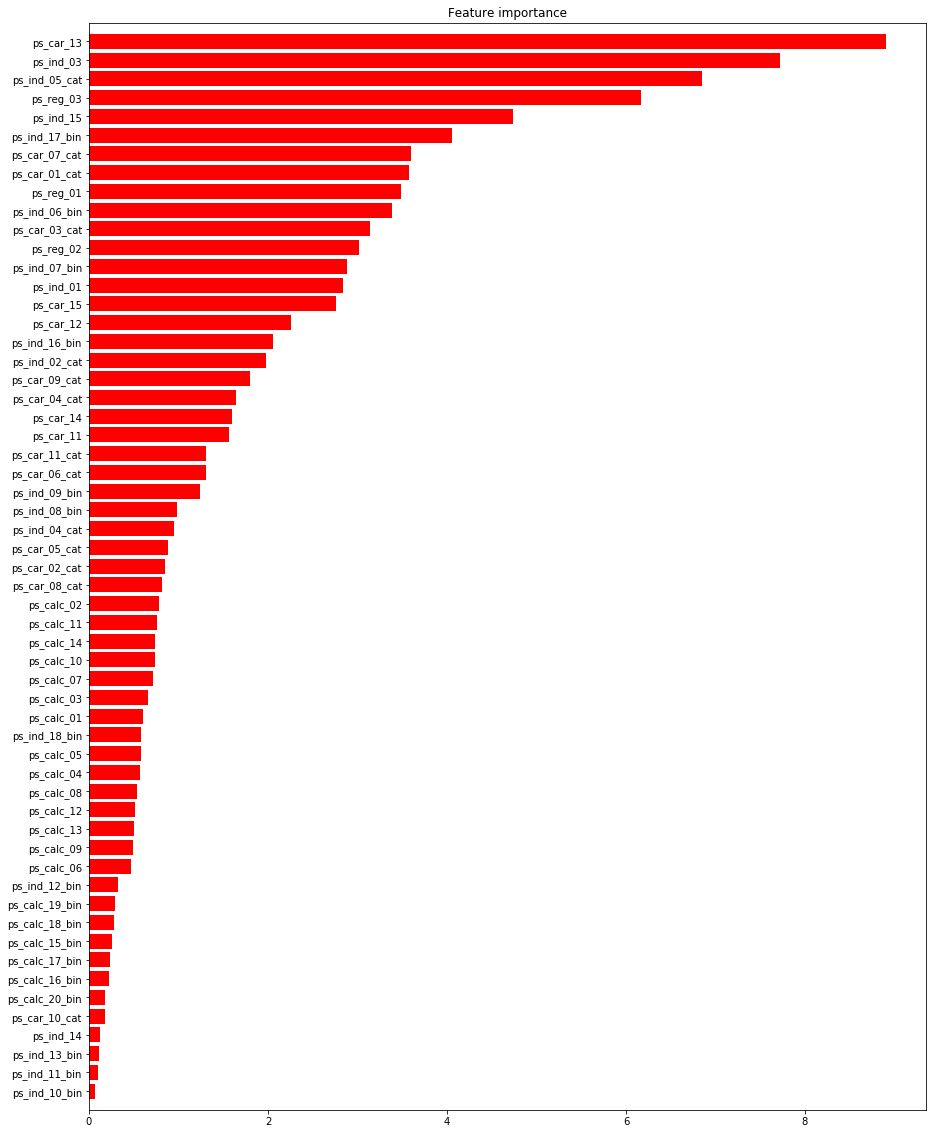

### Отрежу все _calc_ фичи

In [67]:
def trainCatBoost(trainSet, targetSet, params =  {'depth': 7, 'rate': 0.03, 'l2': 8, 'T': 1},
                  folds = 10, maxIter = 1000, verbose = True):
        
    # create log directory    
    dirName = '/tmp/porto/catboost/'+str(params.get('depth'))+'_'+str(params.get('rate'))+\
               '_'+str(params.get('l2'))+'_'+str(params.get('T'))
    
    try:
        os.mkdir(dirName)
    except Exception:
        print Exception

    modelList = list()
    scoreList = list()
    
    prob = np.zeros([trainSet.shape[0]])
    
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
    
    for i, (train_index, val_index) in enumerate(skf.split(trainSet, targetSet)):
        
        model = CatBoostClassifier(verbose= verbose, iterations=maxIter, thread_count=4, eval_metric= "AUC",
                               depth= params['depth'], learning_rate= params['rate'],
                               l2_leaf_reg= params['l2'], bagging_temperature= params['T'],
                               od_type = 'Iter', od_wait = 20, 
                               train_dir= dirName+str(i), random_seed= i)
        
        # create pool
        trainPool = Pool(trainSet.iloc[train_index], targetSet.iloc[train_index], feature_names=trainSet.columns.tolist())
        valPool = Pool(trainSet.iloc[val_index], targetSet.iloc[val_index], feature_names=trainSet.columns.tolist()) 
        
        # fit and estimate the model
        model.fit(trainPool, eval_set=valPool, use_best_model = True)
        
        prob[val_index] = model.predict_proba(valPool)[:,1]
        modelList.append(model)
        print 'Tree amount is ', model.tree_count_ ,' ROC_AUC is', roc_auc_score(targetSet.iloc[val_index], prob[val_index])
        
    score =  roc_auc_score(targetSet,prob)

    return [modelList, score]

In [4]:
def dropCalcFeatures(df): 
    dropList = list()
    for fName in df.columns.tolist():
        if fName.find('_calc_')>(-1):
            dropList.append(fName)
    
    return df.drop(dropList,axis = 1)

In [9]:
X_train2 = dropCalcFeatures(train.drop('target',axis = 1))
y_train = train.target

In [1]:
train2 = dropCalcFeatures(train)
train2.to_pickle('train2.pcl')

NameError: name 'dropCalcFeatures' is not defined

In [6]:
dropCalcFeatures(test).to_pickle('test2.pcl')

In [23]:
test_pool = Pool(test, feature_names= test.columns.tolist())

In [17]:
params =  {'depth': 7, 'rate': 0.03, 'l2': 8, 'T': 1}

Tree amount is  545  ROC_AUC is 0.633477472451

Tree amount is  525  ROC_AUC is 0.632314487042

In [68]:
[modelList, scoreList] = trainCatBoost(X_train2, y_train, params, maxIter= 1000, folds=5)

<type 'exceptions.Exception'>
Borders for float features generated
0:	learn 0.570524149	test 0.5571753848	bestTest 0.5571753848		total: 497ms	remaining: 8m 16s
1:	learn 0.5674119988	test 0.5549241912	bestTest 0.5571753848		total: 886ms	remaining: 7m 22s
2:	learn 0.5784374809	test 0.5666394842	bestTest 0.5666394842		total: 1.33s	remaining: 7m 23s
3:	learn 0.5905221142	test 0.5782227199	bestTest 0.5782227199		total: 1.84s	remaining: 7m 38s
4:	learn 0.5907538284	test 0.5794765509	bestTest 0.5794765509		total: 2.35s	remaining: 7m 47s
5:	learn 0.5985812904	test 0.5852715282	bestTest 0.5852715282		total: 2.86s	remaining: 7m 53s
6:	learn 0.6054299327	test 0.5914520645	bestTest 0.5914520645		total: 3.35s	remaining: 7m 55s
7:	learn 0.60698392	test 0.5945998381	bestTest 0.5945998381		total: 3.89s	remaining: 8m 2s
8:	learn 0.608572012	test 0.595663598	bestTest 0.595663598		total: 4.36s	remaining: 7m 59s
9:	learn 0.6100054195	test 0.5979204104	bestTest 0.5979204104		total: 4.9s	remaining: 8m 5s
10

87:	learn 0.6352024482	test 0.6187522907	bestTest 0.6187522907		total: 45.2s	remaining: 7m 48s
88:	learn 0.6352378877	test 0.6188959052	bestTest 0.6188959052		total: 45.7s	remaining: 7m 47s
89:	learn 0.6352836773	test 0.6189160538	bestTest 0.6189160538		total: 46.2s	remaining: 7m 46s
90:	learn 0.635351498	test 0.6189116978	bestTest 0.6189160538		total: 46.7s	remaining: 7m 46s
91:	learn 0.6354193773	test 0.6188416014	bestTest 0.6189160538		total: 47.3s	remaining: 7m 46s
92:	learn 0.6356282645	test 0.6189751878	bestTest 0.6189751878		total: 47.8s	remaining: 7m 46s
93:	learn 0.6357126119	test 0.619092238	bestTest 0.619092238		total: 48.3s	remaining: 7m 45s
94:	learn 0.6357786749	test 0.6192403592	bestTest 0.6192403592		total: 48.8s	remaining: 7m 44s
95:	learn 0.6357798411	test 0.6191693024	bestTest 0.6192403592		total: 49.3s	remaining: 7m 43s
96:	learn 0.6358110793	test 0.6192409419	bestTest 0.6192409419		total: 49.8s	remaining: 7m 43s
97:	learn 0.6358955281	test 0.619295111	bestTest 0.61

173:	learn 0.6438083985	test 0.6251784647	bestTest 0.6251784647		total: 1m 28s	remaining: 6m 58s
174:	learn 0.6438965045	test 0.6252236304	bestTest 0.6252236304		total: 1m 28s	remaining: 6m 57s
175:	learn 0.6439815039	test 0.6252537971	bestTest 0.6252537971		total: 1m 29s	remaining: 6m 56s
176:	learn 0.6440078896	test 0.625245513	bestTest 0.6252537971		total: 1m 29s	remaining: 6m 55s
177:	learn 0.6441300212	test 0.625354229	bestTest 0.625354229		total: 1m 29s	remaining: 6m 55s
178:	learn 0.6443170298	test 0.6254705258	bestTest 0.6254705258		total: 1m 30s	remaining: 6m 54s
179:	learn 0.6444427571	test 0.6254638009	bestTest 0.6254705258		total: 1m 30s	remaining: 6m 54s
180:	learn 0.6445042859	test 0.6254709919	bestTest 0.6254709919		total: 1m 31s	remaining: 6m 54s
181:	learn 0.6445762699	test 0.6254847994	bestTest 0.6254847994		total: 1m 32s	remaining: 6m 53s
182:	learn 0.6446145245	test 0.6254728646	bestTest 0.6254847994		total: 1m 32s	remaining: 6m 53s
183:	learn 0.6446726538	test 0.62

344:	learn 0.6564014305	test 0.6303284298	bestTest 0.6303364185		total: 2m 54s	remaining: 5m 30s
345:	learn 0.6564779034	test 0.6303822654	bestTest 0.6303822654		total: 2m 54s	remaining: 5m 30s
346:	learn 0.6565617898	test 0.6304627254	bestTest 0.6304627254		total: 2m 55s	remaining: 5m 29s
347:	learn 0.6566172469	test 0.6304777947	bestTest 0.6304777947		total: 2m 55s	remaining: 5m 29s
348:	learn 0.6566369913	test 0.6304742042	bestTest 0.6304777947		total: 2m 56s	remaining: 5m 28s
349:	learn 0.656688665	test 0.6304948451	bestTest 0.6304948451		total: 2m 56s	remaining: 5m 28s
350:	learn 0.656729245	test 0.6304939771	bestTest 0.6304948451		total: 2m 57s	remaining: 5m 27s
351:	learn 0.6567374055	test 0.6304981442	bestTest 0.6304981442		total: 2m 57s	remaining: 5m 27s
352:	learn 0.6567581097	test 0.630497431	bestTest 0.6304981442		total: 2m 58s	remaining: 5m 26s
353:	learn 0.6568126206	test 0.6305434566	bestTest 0.6305434566		total: 2m 58s	remaining: 5m 26s
354:	learn 0.6568989127	test 0.63

430:	learn 0.6607826578	test 0.6314466059	bestTest 0.6314466059		total: 3m 37s	remaining: 4m 47s
431:	learn 0.6608058288	test 0.6314493948	bestTest 0.6314493948		total: 3m 38s	remaining: 4m 46s
432:	learn 0.6608574373	test 0.6314781329	bestTest 0.6314781329		total: 3m 38s	remaining: 4m 46s
433:	learn 0.6608877013	test 0.6314799613	bestTest 0.6314799613		total: 3m 39s	remaining: 4m 45s
434:	learn 0.6609337033	test 0.6314935116	bestTest 0.6314935116		total: 3m 39s	remaining: 4m 45s
435:	learn 0.6609575552	test 0.6314855591	bestTest 0.6314935116		total: 3m 40s	remaining: 4m 44s
436:	learn 0.6610536069	test 0.631504474	bestTest 0.631504474		total: 3m 40s	remaining: 4m 44s
437:	learn 0.6610855875	test 0.6314828607	bestTest 0.631504474		total: 3m 41s	remaining: 4m 43s
438:	learn 0.6611143265	test 0.6314601964	bestTest 0.631504474		total: 3m 41s	remaining: 4m 43s
439:	learn 0.661151846	test 0.6314775824	bestTest 0.631504474		total: 3m 42s	remaining: 4m 42s
440:	learn 0.6611829507	test 0.63146

516:	learn 0.6652872611	test 0.6321869184	bestTest 0.6321869184		total: 4m 21s	remaining: 4m 4s
517:	learn 0.6653218562	test 0.632187696	bestTest 0.632187696		total: 4m 21s	remaining: 4m 3s
518:	learn 0.6654040181	test 0.6322146519	bestTest 0.6322146519		total: 4m 22s	remaining: 4m 3s
519:	learn 0.6654340049	test 0.6322326366	bestTest 0.6322326366		total: 4m 22s	remaining: 4m 2s
520:	learn 0.6655026252	test 0.6322458635	bestTest 0.6322458635		total: 4m 23s	remaining: 4m 1s
521:	learn 0.6655174957	test 0.6322416943	bestTest 0.6322458635		total: 4m 23s	remaining: 4m 1s
522:	learn 0.6655903892	test 0.6322358534	bestTest 0.6322458635		total: 4m 24s	remaining: 4m
523:	learn 0.6656113635	test 0.6322286965	bestTest 0.6322458635		total: 4m 24s	remaining: 4m
524:	learn 0.6656306641	test 0.6322370108	bestTest 0.6322458635		total: 4m 25s	remaining: 3m 59s
525:	learn 0.6656916735	test 0.6322590963	bestTest 0.6322590963		total: 4m 25s	remaining: 3m 59s
526:	learn 0.665721236	test 0.6322625944	bestT

Tree amount is  579  ROC_AUC is 0.632339656792
Borders for float features generated
0:	learn 0.5786461313	test 0.5805588741	bestTest 0.5805588741		total: 511ms	remaining: 8m 30s
1:	learn 0.5924823564	test 0.5947093347	bestTest 0.5947093347		total: 934ms	remaining: 7m 45s
2:	learn 0.5990243475	test 0.5987018972	bestTest 0.5987018972		total: 1.43s	remaining: 7m 56s
3:	learn 0.5981884218	test 0.5971534032	bestTest 0.5987018972		total: 1.96s	remaining: 8m 8s
4:	learn 0.6003099627	test 0.6011945572	bestTest 0.6011945572		total: 2.46s	remaining: 8m 9s
5:	learn 0.6035802945	test 0.6029046594	bestTest 0.6029046594		total: 2.95s	remaining: 8m 8s
6:	learn 0.6075822919	test 0.6070351483	bestTest 0.6070351483		total: 3.42s	remaining: 8m 5s
7:	learn 0.6092043243	test 0.6085474468	bestTest 0.6085474468		total: 3.9s	remaining: 8m 3s
8:	learn 0.6114475413	test 0.6098426832	bestTest 0.6098426832		total: 4.43s	remaining: 8m 7s
9:	learn 0.6118862531	test 0.6101458916	bestTest 0.6101458916		total: 4.93s	r

87:	learn 0.6320097175	test 0.6306459259	bestTest 0.6306459259		total: 44s	remaining: 7m 35s
88:	learn 0.6319854096	test 0.6305834043	bestTest 0.6306459259		total: 44.4s	remaining: 7m 34s
89:	learn 0.6321451998	test 0.6307289697	bestTest 0.6307289697		total: 44.9s	remaining: 7m 34s
90:	learn 0.6322707145	test 0.6308557628	bestTest 0.6308557628		total: 45.4s	remaining: 7m 33s
91:	learn 0.6325495093	test 0.6311135825	bestTest 0.6311135825		total: 45.9s	remaining: 7m 33s
92:	learn 0.6326095879	test 0.631260253	bestTest 0.631260253		total: 46.4s	remaining: 7m 32s
93:	learn 0.6326335191	test 0.6312798671	bestTest 0.6312798671		total: 46.9s	remaining: 7m 32s
94:	learn 0.6326533728	test 0.6313235078	bestTest 0.6313235078		total: 47.5s	remaining: 7m 32s
95:	learn 0.6330268147	test 0.6316761716	bestTest 0.6316761716		total: 47.9s	remaining: 7m 31s
96:	learn 0.6330625403	test 0.6317691944	bestTest 0.6317691944		total: 48.5s	remaining: 7m 31s
97:	learn 0.6331524098	test 0.6318575748	bestTest 0.63

173:	learn 0.6402272935	test 0.6366147647	bestTest 0.6366147647		total: 1m 27s	remaining: 6m 55s
174:	learn 0.640379692	test 0.6367440794	bestTest 0.6367440794		total: 1m 28s	remaining: 6m 55s
175:	learn 0.6404447067	test 0.636734007	bestTest 0.6367440794		total: 1m 28s	remaining: 6m 54s
176:	learn 0.6404443285	test 0.6367104909	bestTest 0.6367440794		total: 1m 29s	remaining: 6m 54s
177:	learn 0.6405606887	test 0.6367288774	bestTest 0.6367440794		total: 1m 29s	remaining: 6m 53s
178:	learn 0.6406061066	test 0.6367534243	bestTest 0.6367534243		total: 1m 30s	remaining: 6m 53s
179:	learn 0.6407520024	test 0.6368393113	bestTest 0.6368393113		total: 1m 30s	remaining: 6m 52s
180:	learn 0.6407488736	test 0.6368347222	bestTest 0.6368393113		total: 1m 30s	remaining: 6m 51s
181:	learn 0.6408221871	test 0.6368156063	bestTest 0.6368393113		total: 1m 31s	remaining: 6m 51s
182:	learn 0.6408914005	test 0.6368547121	bestTest 0.6368547121		total: 1m 31s	remaining: 6m 50s
183:	learn 0.6409825412	test 0.6

343:	learn 0.653263528	test 0.6418851917	bestTest 0.6418851917		total: 2m 53s	remaining: 5m 31s
344:	learn 0.6532984307	test 0.641888957	bestTest 0.641888957		total: 2m 54s	remaining: 5m 30s
345:	learn 0.6533688664	test 0.6419109703	bestTest 0.6419109703		total: 2m 54s	remaining: 5m 30s
346:	learn 0.6533918852	test 0.641934183	bestTest 0.641934183		total: 2m 55s	remaining: 5m 29s
347:	learn 0.6534415037	test 0.6419601766	bestTest 0.6419601766		total: 2m 55s	remaining: 5m 29s
348:	learn 0.6534991418	test 0.6419842794	bestTest 0.6419842794		total: 2m 56s	remaining: 5m 29s
349:	learn 0.6535924647	test 0.6419896782	bestTest 0.6419896782		total: 2m 56s	remaining: 5m 28s
350:	learn 0.6536447146	test 0.6420132466	bestTest 0.6420132466		total: 2m 57s	remaining: 5m 28s
351:	learn 0.6537746595	test 0.642065957	bestTest 0.642065957		total: 2m 57s	remaining: 5m 27s
352:	learn 0.653819988	test 0.6421055631	bestTest 0.6421055631		total: 2m 58s	remaining: 5m 27s
353:	learn 0.6539032916	test 0.6421326

429:	learn 0.6581853717	test 0.6427365529	bestTest 0.6427365529		total: 3m 38s	remaining: 4m 49s
430:	learn 0.6582522289	test 0.6427406156	bestTest 0.6427406156		total: 3m 38s	remaining: 4m 48s
431:	learn 0.6583209188	test 0.6427430427	bestTest 0.6427430427		total: 3m 39s	remaining: 4m 48s
432:	learn 0.6583685815	test 0.6427461229	bestTest 0.6427461229		total: 3m 39s	remaining: 4m 47s
433:	learn 0.6584451817	test 0.6427745034	bestTest 0.6427745034		total: 3m 40s	remaining: 4m 47s
434:	learn 0.6585373047	test 0.6427689499	bestTest 0.6427745034		total: 3m 40s	remaining: 4m 46s
435:	learn 0.6586118401	test 0.6428274288	bestTest 0.6428274288		total: 3m 41s	remaining: 4m 46s
436:	learn 0.658679333	test 0.6428292431	bestTest 0.6428292431		total: 3m 41s	remaining: 4m 45s
437:	learn 0.6587650238	test 0.6427751443	bestTest 0.6428292431		total: 3m 42s	remaining: 4m 45s
438:	learn 0.6588036417	test 0.6427722772	bestTest 0.6428292431		total: 3m 42s	remaining: 4m 44s
439:	learn 0.6588891585	test 0.

42:	learn 0.6292050643	test 0.6252921756	bestTest 0.6257783142		total: 21.5s	remaining: 7m 59s
43:	learn 0.6289857283	test 0.6250921578	bestTest 0.6257783142		total: 22.1s	remaining: 7m 59s
44:	learn 0.6291559459	test 0.6250049327	bestTest 0.6257783142		total: 22.5s	remaining: 7m 58s
45:	learn 0.6294073426	test 0.6252222661	bestTest 0.6257783142		total: 22.9s	remaining: 7m 55s
46:	learn 0.6295561507	test 0.6255816609	bestTest 0.6257783142		total: 23.4s	remaining: 7m 54s
47:	learn 0.6298127733	test 0.6254469906	bestTest 0.6257783142		total: 23.9s	remaining: 7m 53s
48:	learn 0.6296617517	test 0.6253062333	bestTest 0.6257783142		total: 24.4s	remaining: 7m 52s
49:	learn 0.6298709714	test 0.6256697972	bestTest 0.6257783142		total: 24.9s	remaining: 7m 52s
50:	learn 0.6297332677	test 0.6255813545	bestTest 0.6257783142		total: 25.4s	remaining: 7m 52s
51:	learn 0.629341912	test 0.6252173646	bestTest 0.6257783142		total: 25.9s	remaining: 7m 51s
52:	learn 0.6293564259	test 0.6251270533	bestTest 0

129:	learn 0.6378133213	test 0.632844633	bestTest 0.6328831622		total: 1m 4s	remaining: 7m 12s
130:	learn 0.6378404358	test 0.6328827503	bestTest 0.6328831622		total: 1m 5s	remaining: 7m 11s
131:	learn 0.6379282356	test 0.6329364714	bestTest 0.6329364714		total: 1m 5s	remaining: 7m 11s
132:	learn 0.6380718152	test 0.6329619244	bestTest 0.6329619244		total: 1m 6s	remaining: 7m 10s
133:	learn 0.6381350417	test 0.6329876567	bestTest 0.6329876567		total: 1m 6s	remaining: 7m 10s
134:	learn 0.6382046997	test 0.6330137648	bestTest 0.6330137648		total: 1m 7s	remaining: 7m 9s
135:	learn 0.6384978704	test 0.6332254322	bestTest 0.6332254322		total: 1m 7s	remaining: 7m 9s
136:	learn 0.6384910065	test 0.6332768507	bestTest 0.6332768507		total: 1m 7s	remaining: 7m 8s
137:	learn 0.6386552299	test 0.6333644636	bestTest 0.6333644636		total: 1m 8s	remaining: 7m 7s
138:	learn 0.6387613191	test 0.6333533846	bestTest 0.6333644636		total: 1m 8s	remaining: 7m 7s
139:	learn 0.6389452996	test 0.633463278	bestT

215:	learn 0.6455403101	test 0.6368596991	bestTest 0.6368596991		total: 1m 47s	remaining: 6m 31s
216:	learn 0.6456957722	test 0.636918399	bestTest 0.636918399		total: 1m 48s	remaining: 6m 31s
217:	learn 0.6457289968	test 0.636923613	bestTest 0.636923613		total: 1m 48s	remaining: 6m 30s
218:	learn 0.6458490921	test 0.6370023109	bestTest 0.6370023109		total: 1m 49s	remaining: 6m 30s
219:	learn 0.6460081473	test 0.6370681577	bestTest 0.6370681577		total: 1m 49s	remaining: 6m 29s
220:	learn 0.6462168939	test 0.6371669359	bestTest 0.6371669359		total: 1m 50s	remaining: 6m 29s
221:	learn 0.6462998711	test 0.6371737533	bestTest 0.6371737533		total: 1m 50s	remaining: 6m 28s
222:	learn 0.6463495241	test 0.6371775849	bestTest 0.6371775849		total: 1m 51s	remaining: 6m 28s
223:	learn 0.6464750327	test 0.6371640185	bestTest 0.6371775849		total: 1m 51s	remaining: 6m 27s
224:	learn 0.6465288454	test 0.6371932007	bestTest 0.6371932007		total: 1m 52s	remaining: 6m 27s
225:	learn 0.6467151618	test 0.637

301:	learn 0.6520133459	test 0.6391835809	bestTest 0.6391835809		total: 2m 31s	remaining: 5m 50s
302:	learn 0.652023086	test 0.6391830886	bestTest 0.6391835809		total: 2m 32s	remaining: 5m 50s
303:	learn 0.6520610225	test 0.6391682383	bestTest 0.6391835809		total: 2m 32s	remaining: 5m 49s
304:	learn 0.6521373492	test 0.6392025501	bestTest 0.6392025501		total: 2m 33s	remaining: 5m 49s
305:	learn 0.6521645032	test 0.6392110693	bestTest 0.6392110693		total: 2m 33s	remaining: 5m 49s
306:	learn 0.6522379423	test 0.6392293333	bestTest 0.6392293333		total: 2m 34s	remaining: 5m 48s
307:	learn 0.6522372069	test 0.6392319895	bestTest 0.6392319895		total: 2m 34s	remaining: 5m 48s
308:	learn 0.6524089477	test 0.6392815293	bestTest 0.6392815293		total: 2m 35s	remaining: 5m 47s
309:	learn 0.652447368	test 0.6393113203	bestTest 0.6393113203		total: 2m 35s	remaining: 5m 47s
310:	learn 0.6525308203	test 0.6393762529	bestTest 0.6393762529		total: 2m 36s	remaining: 5m 46s
311:	learn 0.6526187659	test 0.6

387:	learn 0.6565660885	test 0.6405595485	bestTest 0.6405595485		total: 3m 16s	remaining: 5m 9s
388:	learn 0.656604365	test 0.6405569084	bestTest 0.6405595485		total: 3m 16s	remaining: 5m 9s
389:	learn 0.6566594844	test 0.6405766411	bestTest 0.6405766411		total: 3m 17s	remaining: 5m 8s
390:	learn 0.6566781456	test 0.6405817707	bestTest 0.6405817707		total: 3m 17s	remaining: 5m 8s
391:	learn 0.6567711861	test 0.6406566953	bestTest 0.6406566953		total: 3m 18s	remaining: 5m 7s
392:	learn 0.6568551788	test 0.6406402757	bestTest 0.6406566953		total: 3m 18s	remaining: 5m 7s
393:	learn 0.6569734255	test 0.640686223	bestTest 0.640686223		total: 3m 19s	remaining: 5m 6s
394:	learn 0.656986327	test 0.6406821443	bestTest 0.640686223		total: 3m 19s	remaining: 5m 6s
395:	learn 0.657005258	test 0.6406988129	bestTest 0.6406988129		total: 3m 20s	remaining: 5m 5s
396:	learn 0.6570379165	test 0.6407076215	bestTest 0.6407076215		total: 3m 20s	remaining: 5m 5s
397:	learn 0.6571268514	test 0.6407306112	best

473:	learn 0.6610615919	test 0.6418465711	bestTest 0.6418530951		total: 4m 3s	remaining: 4m 30s
474:	learn 0.6611057155	test 0.6418581685	bestTest 0.6418581685		total: 4m 4s	remaining: 4m 29s
475:	learn 0.6611738319	test 0.6419026892	bestTest 0.6419026892		total: 4m 4s	remaining: 4m 29s
476:	learn 0.6612179081	test 0.6419135994	bestTest 0.6419135994		total: 4m 4s	remaining: 4m 28s
477:	learn 0.6612762419	test 0.6418784859	bestTest 0.6419135994		total: 4m 5s	remaining: 4m 28s
478:	learn 0.6613320256	test 0.6419022954	bestTest 0.6419135994		total: 4m 6s	remaining: 4m 27s
479:	learn 0.6613901423	test 0.6419127113	bestTest 0.6419135994		total: 4m 6s	remaining: 4m 27s
480:	learn 0.6614592986	test 0.6419365368	bestTest 0.6419365368		total: 4m 7s	remaining: 4m 26s
481:	learn 0.6615235143	test 0.6419582266	bestTest 0.6419582266		total: 4m 7s	remaining: 4m 25s
482:	learn 0.6615401973	test 0.6419731211	bestTest 0.6419731211		total: 4m 8s	remaining: 4m 25s
483:	learn 0.6615621983	test 0.641990826

559:	learn 0.6653797309	test 0.6422336753	bestTest 0.642255797		total: 4m 48s	remaining: 3m 46s
560:	learn 0.6654376893	test 0.6422174828	bestTest 0.642255797		total: 4m 48s	remaining: 3m 45s
561:	learn 0.6655773634	test 0.6422754615	bestTest 0.6422754615		total: 4m 49s	remaining: 3m 45s
562:	learn 0.6656212976	test 0.6422792609	bestTest 0.6422792609		total: 4m 49s	remaining: 3m 44s
563:	learn 0.6656336119	test 0.6422940088	bestTest 0.6422940088		total: 4m 50s	remaining: 3m 44s
564:	learn 0.6656800854	test 0.6422865203	bestTest 0.6422940088		total: 4m 50s	remaining: 3m 44s
565:	learn 0.6657748076	test 0.6423090479	bestTest 0.6423090479		total: 4m 51s	remaining: 3m 43s
566:	learn 0.6658263407	test 0.6423088791	bestTest 0.6423090479		total: 4m 52s	remaining: 3m 43s
567:	learn 0.6658841395	test 0.6423357608	bestTest 0.6423357608		total: 4m 52s	remaining: 3m 42s
568:	learn 0.6659368886	test 0.6423331849	bestTest 0.6423357608		total: 4m 53s	remaining: 3m 41s
569:	learn 0.6659731141	test 0.6

644:	learn 0.6696842381	test 0.6430033568	bestTest 0.6430059025		total: 5m 36s	remaining: 3m 5s
645:	learn 0.6697230375	test 0.6430026114	bestTest 0.6430059025		total: 5m 37s	remaining: 3m 4s
646:	learn 0.6697504908	test 0.6430371382	bestTest 0.6430371382		total: 5m 37s	remaining: 3m 4s
647:	learn 0.6698106347	test 0.6430425491	bestTest 0.6430425491		total: 5m 38s	remaining: 3m 3s
648:	learn 0.6698496074	test 0.6430503148	bestTest 0.6430503148		total: 5m 38s	remaining: 3m 3s
649:	learn 0.6699481013	test 0.6430462923	bestTest 0.6430503148		total: 5m 39s	remaining: 3m 2s
650:	learn 0.6699933419	test 0.6430408211	bestTest 0.6430503148		total: 5m 40s	remaining: 3m 2s
651:	learn 0.6700089791	test 0.6430257418	bestTest 0.6430503148		total: 5m 40s	remaining: 3m 1s
652:	learn 0.670060729	test 0.6430363063	bestTest 0.6430503148		total: 5m 41s	remaining: 3m 1s
653:	learn 0.6700851893	test 0.6430325089	bestTest 0.6430503148		total: 5m 41s	remaining: 3m
654:	learn 0.670100308	test 0.6430332121	bes

730:	learn 0.6736113668	test 0.643512239	bestTest 0.6435449956		total: 6m 23s	remaining: 2m 21s
731:	learn 0.6736461364	test 0.6435128619	bestTest 0.6435449956		total: 6m 24s	remaining: 2m 20s
732:	learn 0.673693394	test 0.6435170511	bestTest 0.6435449956		total: 6m 24s	remaining: 2m 20s
733:	learn 0.6737484634	test 0.6435287509	bestTest 0.6435449956		total: 6m 25s	remaining: 2m 19s
734:	learn 0.6737932568	test 0.6435501936	bestTest 0.6435501936		total: 6m 25s	remaining: 2m 19s
735:	learn 0.6738360025	test 0.6435491347	bestTest 0.6435501936		total: 6m 26s	remaining: 2m 18s
736:	learn 0.6738828984	test 0.6435504748	bestTest 0.6435504748		total: 6m 26s	remaining: 2m 18s
737:	learn 0.6739619449	test 0.643518532	bestTest 0.6435504748		total: 6m 27s	remaining: 2m 17s
738:	learn 0.6739892202	test 0.6435043929	bestTest 0.6435504748		total: 6m 28s	remaining: 2m 17s
739:	learn 0.6740036515	test 0.6435067839	bestTest 0.6435504748		total: 6m 28s	remaining: 2m 16s
740:	learn 0.6740481262	test 0.64

816:	learn 0.6770633248	test 0.643703605	bestTest 0.6437542359		total: 7m 11s	remaining: 1m 36s
817:	learn 0.6770802007	test 0.6436898839	bestTest 0.6437542359		total: 7m 12s	remaining: 1m 36s
818:	learn 0.6771109078	test 0.6436885257	bestTest 0.6437542359		total: 7m 12s	remaining: 1m 35s
819:	learn 0.677160141	test 0.6437028978	bestTest 0.6437542359		total: 7m 13s	remaining: 1m 35s
820:	learn 0.6771661029	test 0.643697077	bestTest 0.6437542359		total: 7m 13s	remaining: 1m 34s
821:	learn 0.6772131602	test 0.6436893515	bestTest 0.6437542359		total: 7m 14s	remaining: 1m 34s
822:	learn 0.677235468	test 0.6436584373	bestTest 0.6437542359		total: 7m 15s	remaining: 1m 33s
823:	learn 0.6772693622	test 0.6436772478	bestTest 0.6437542359		total: 7m 15s	remaining: 1m 33s
824:	learn 0.6772931422	test 0.6436632254	bestTest 0.6437542359		total: 7m 16s	remaining: 1m 32s
825:	learn 0.6773403351	test 0.6436524498	bestTest 0.6437542359		total: 7m 16s	remaining: 1m 32s
826:	learn 0.6773824658	test 0.643

74:	learn 0.6323051068	test 0.630743691	bestTest 0.6309410765		total: 37.5s	remaining: 7m 42s
75:	learn 0.6325097688	test 0.6309499152	bestTest 0.6309499152		total: 38s	remaining: 7m 42s
76:	learn 0.6325077189	test 0.6309707512	bestTest 0.6309707512		total: 38.5s	remaining: 7m 41s
77:	learn 0.6326073045	test 0.6311356951	bestTest 0.6311356951		total: 39s	remaining: 7m 40s
78:	learn 0.6326130666	test 0.6311263883	bestTest 0.6311356951		total: 39.5s	remaining: 7m 40s
79:	learn 0.6327353771	test 0.6311701398	bestTest 0.6311701398		total: 40s	remaining: 7m 40s
80:	learn 0.6328036496	test 0.6312558206	bestTest 0.6312558206		total: 40.5s	remaining: 7m 40s
81:	learn 0.6329897077	test 0.6313122024	bestTest 0.6313122024		total: 41.1s	remaining: 7m 40s
82:	learn 0.6331016912	test 0.6314260831	bestTest 0.6314260831		total: 41.6s	remaining: 7m 40s
83:	learn 0.6331417487	test 0.6315208175	bestTest 0.6315208175		total: 42.1s	remaining: 7m 39s
84:	learn 0.6333483448	test 0.6318117861	bestTest 0.63181

160:	learn 0.6397999073	test 0.6362627393	bestTest 0.6362627393		total: 1m 21s	remaining: 7m 3s
161:	learn 0.6399145962	test 0.6362988658	bestTest 0.6362988658		total: 1m 21s	remaining: 7m 2s
162:	learn 0.6400016218	test 0.636323654	bestTest 0.636323654		total: 1m 22s	remaining: 7m 1s
163:	learn 0.6401949167	test 0.6364080046	bestTest 0.6364080046		total: 1m 22s	remaining: 7m 1s
164:	learn 0.64025052	test 0.6364460519	bestTest 0.6364460519		total: 1m 23s	remaining: 7m
165:	learn 0.6403319436	test 0.6365003802	bestTest 0.6365003802		total: 1m 23s	remaining: 7m
166:	learn 0.6405108509	test 0.6366020044	bestTest 0.6366020044		total: 1m 24s	remaining: 6m 59s
167:	learn 0.6406791903	test 0.6366778217	bestTest 0.6366778217		total: 1m 24s	remaining: 6m 59s
168:	learn 0.6406640434	test 0.6367007715	bestTest 0.6367007715		total: 1m 25s	remaining: 6m 58s
169:	learn 0.6408104622	test 0.6367066486	bestTest 0.6367066486		total: 1m 25s	remaining: 6m 58s
170:	learn 0.6408374137	test 0.6367209263	best

245:	learn 0.6464197804	test 0.6391700202	bestTest 0.639171495		total: 2m 4s	remaining: 6m 21s
246:	learn 0.6464579774	test 0.6391804221	bestTest 0.6391804221		total: 2m 5s	remaining: 6m 21s
247:	learn 0.6465350521	test 0.639195361	bestTest 0.639195361		total: 2m 5s	remaining: 6m 20s
248:	learn 0.6466422047	test 0.6392113828	bestTest 0.6392113828		total: 2m 6s	remaining: 6m 20s
249:	learn 0.6467916366	test 0.6392402558	bestTest 0.6392402558		total: 2m 6s	remaining: 6m 19s
250:	learn 0.6468403923	test 0.6392996374	bestTest 0.6392996374		total: 2m 7s	remaining: 6m 19s
251:	learn 0.6469326072	test 0.6393565014	bestTest 0.6393565014		total: 2m 7s	remaining: 6m 19s
252:	learn 0.647030387	test 0.639432371	bestTest 0.639432371		total: 2m 8s	remaining: 6m 18s
253:	learn 0.6471372094	test 0.6394850838	bestTest 0.6394850838		total: 2m 8s	remaining: 6m 18s
254:	learn 0.6472266187	test 0.6394985961	bestTest 0.6394985961		total: 2m 9s	remaining: 6m 17s
255:	learn 0.6472922534	test 0.6395316363	best

331:	learn 0.6523617488	test 0.6410633193	bestTest 0.6410633193		total: 2m 49s	remaining: 5m 40s
332:	learn 0.6524297754	test 0.6410713825	bestTest 0.6410713825		total: 2m 49s	remaining: 5m 39s
333:	learn 0.6525038276	test 0.6410870848	bestTest 0.6410870848		total: 2m 50s	remaining: 5m 39s
334:	learn 0.6525387576	test 0.6411184212	bestTest 0.6411184212		total: 2m 50s	remaining: 5m 38s
335:	learn 0.6526002941	test 0.641188056	bestTest 0.641188056		total: 2m 51s	remaining: 5m 38s
336:	learn 0.6527152129	test 0.6411596592	bestTest 0.641188056		total: 2m 51s	remaining: 5m 37s
337:	learn 0.6527664311	test 0.6411798784	bestTest 0.641188056		total: 2m 52s	remaining: 5m 37s
338:	learn 0.6528491184	test 0.6411813331	bestTest 0.641188056		total: 2m 52s	remaining: 5m 36s
339:	learn 0.6529216974	test 0.6412162781	bestTest 0.6412162781		total: 2m 53s	remaining: 5m 36s
340:	learn 0.6529716878	test 0.641206065	bestTest 0.6412162781		total: 2m 53s	remaining: 5m 35s
341:	learn 0.6530014352	test 0.64122

417:	learn 0.6573130697	test 0.6424650757	bestTest 0.6424650757		total: 3m 33s	remaining: 4m 57s
418:	learn 0.6573676988	test 0.6424810895	bestTest 0.6424810895		total: 3m 34s	remaining: 4m 57s
419:	learn 0.6574039555	test 0.6425044632	bestTest 0.6425044632		total: 3m 34s	remaining: 4m 56s
420:	learn 0.6574481	test 0.6425046762	bestTest 0.6425046762		total: 3m 35s	remaining: 4m 55s
421:	learn 0.6574628646	test 0.6424937358	bestTest 0.6425046762		total: 3m 35s	remaining: 4m 55s
422:	learn 0.657519639	test 0.6424825402	bestTest 0.6425046762		total: 3m 36s	remaining: 4m 54s
423:	learn 0.6575489744	test 0.6425084596	bestTest 0.6425084596		total: 3m 36s	remaining: 4m 54s
424:	learn 0.6575953828	test 0.642530027	bestTest 0.642530027		total: 3m 37s	remaining: 4m 53s
425:	learn 0.657654525	test 0.6425488075	bestTest 0.6425488075		total: 3m 37s	remaining: 4m 53s
426:	learn 0.6576808126	test 0.6425529205	bestTest 0.6425529205		total: 3m 38s	remaining: 4m 52s
427:	learn 0.6577318173	test 0.642553

503:	learn 0.6617410171	test 0.6433377565	bestTest 0.6433550924		total: 4m 20s	remaining: 4m 16s
504:	learn 0.6617837172	test 0.6433680963	bestTest 0.6433680963		total: 4m 20s	remaining: 4m 15s
505:	learn 0.6618061541	test 0.6433770375	bestTest 0.6433770375		total: 4m 21s	remaining: 4m 15s
506:	learn 0.6619020494	test 0.6433991594	bestTest 0.6433991594		total: 4m 22s	remaining: 4m 14s
507:	learn 0.6619318643	test 0.6434108493	bestTest 0.6434108493		total: 4m 22s	remaining: 4m 14s
508:	learn 0.6619882892	test 0.6434338673	bestTest 0.6434338673		total: 4m 23s	remaining: 4m 13s
509:	learn 0.6620617391	test 0.6434313919	bestTest 0.6434338673		total: 4m 23s	remaining: 4m 13s
510:	learn 0.6620759821	test 0.6434325211	bestTest 0.6434338673		total: 4m 24s	remaining: 4m 12s
511:	learn 0.6621193917	test 0.6434262442	bestTest 0.6434338673		total: 4m 24s	remaining: 4m 12s
512:	learn 0.6621501897	test 0.6434442391	bestTest 0.6434442391		total: 4m 25s	remaining: 4m 11s
513:	learn 0.6621906731	test 0

589:	learn 0.6658327055	test 0.6437232285	bestTest 0.6437709283		total: 5m 6s	remaining: 3m 32s
590:	learn 0.6658446337	test 0.6437278136	bestTest 0.6437709283		total: 5m 6s	remaining: 3m 32s
591:	learn 0.6659151446	test 0.6437487883	bestTest 0.6437709283		total: 5m 7s	remaining: 3m 31s
592:	learn 0.6659390606	test 0.6437548803	bestTest 0.6437709283		total: 5m 7s	remaining: 3m 31s
593:	learn 0.666005107	test 0.6437406528	bestTest 0.6437709283		total: 5m 8s	remaining: 3m 30s
594:	learn 0.666037199	test 0.6437459472	bestTest 0.6437709283		total: 5m 8s	remaining: 3m 30s
595:	learn 0.6661032841	test 0.6437447557	bestTest 0.6437709283		total: 5m 9s	remaining: 3m 29s
596:	learn 0.6661233304	test 0.6437359612	bestTest 0.6437709283		total: 5m 9s	remaining: 3m 29s
597:	learn 0.6661758621	test 0.6437358768	bestTest 0.6437709283		total: 5m 10s	remaining: 3m 28s
598:	learn 0.666318389	test 0.6437317257	bestTest 0.6437709283		total: 5m 10s	remaining: 3m 28s
599:	learn 0.6663475964	test 0.6437377655

65:	learn 0.6285576112	test 0.6297758803	bestTest 0.6297758803		total: 32.4s	remaining: 7m 38s
66:	learn 0.6284509139	test 0.6296609605	bestTest 0.6297758803		total: 32.9s	remaining: 7m 38s
67:	learn 0.628715757	test 0.629758026	bestTest 0.6297758803		total: 33.4s	remaining: 7m 37s
68:	learn 0.6286235089	test 0.6296199421	bestTest 0.6297758803		total: 33.9s	remaining: 7m 37s
69:	learn 0.6284998078	test 0.6293942445	bestTest 0.6297758803		total: 34.3s	remaining: 7m 35s
70:	learn 0.6287940011	test 0.6295836747	bestTest 0.6297758803		total: 34.8s	remaining: 7m 35s
71:	learn 0.6288678656	test 0.629570304	bestTest 0.6297758803		total: 35.3s	remaining: 7m 34s
72:	learn 0.629256074	test 0.6298718907	bestTest 0.6298718907		total: 35.8s	remaining: 7m 34s
73:	learn 0.6294594765	test 0.6299801624	bestTest 0.6299801624		total: 36.4s	remaining: 7m 34s
74:	learn 0.6295252808	test 0.6299958583	bestTest 0.6299958583		total: 36.9s	remaining: 7m 34s
75:	learn 0.6297890304	test 0.6303595675	bestTest 0.63

237:	learn 0.6473497001	test 0.6393852758	bestTest 0.6393852758		total: 2m 4s	remaining: 6m 37s
238:	learn 0.6474223612	test 0.6394068461	bestTest 0.6394068461		total: 2m 4s	remaining: 6m 37s
239:	learn 0.6475053264	test 0.6394178956	bestTest 0.6394178956		total: 2m 5s	remaining: 6m 37s
240:	learn 0.6475657251	test 0.6394303548	bestTest 0.6394303548		total: 2m 6s	remaining: 6m 37s
241:	learn 0.647619804	test 0.6394055368	bestTest 0.6394303548		total: 2m 6s	remaining: 6m 36s
242:	learn 0.6476541393	test 0.6394003557	bestTest 0.6394303548		total: 2m 7s	remaining: 6m 36s
243:	learn 0.6476825242	test 0.6394418967	bestTest 0.6394418967		total: 2m 7s	remaining: 6m 35s
244:	learn 0.6477368174	test 0.6394265685	bestTest 0.6394418967		total: 2m 8s	remaining: 6m 35s
245:	learn 0.6478508703	test 0.639499037	bestTest 0.639499037		total: 2m 8s	remaining: 6m 34s
246:	learn 0.64785956	test 0.6395125705	bestTest 0.6395125705		total: 2m 9s	remaining: 6m 34s
247:	learn 0.6480094217	test 0.6395069292	bes

408:	learn 0.6578908598	test 0.6419173338	bestTest 0.641933082		total: 3m 49s	remaining: 5m 31s
409:	learn 0.6579492429	test 0.6419416916	bestTest 0.6419416916		total: 3m 49s	remaining: 5m 30s
410:	learn 0.6580471242	test 0.6419889884	bestTest 0.6419889884		total: 3m 50s	remaining: 5m 30s
411:	learn 0.6581351588	test 0.6419680431	bestTest 0.6419889884		total: 3m 51s	remaining: 5m 29s
412:	learn 0.6582004895	test 0.6420192548	bestTest 0.6420192548		total: 3m 51s	remaining: 5m 29s
413:	learn 0.6582462948	test 0.6420117585	bestTest 0.6420192548		total: 3m 52s	remaining: 5m 28s
414:	learn 0.6582998035	test 0.6420000639	bestTest 0.6420192548		total: 3m 52s	remaining: 5m 28s
415:	learn 0.6584091828	test 0.6419841932	bestTest 0.6420192548		total: 3m 53s	remaining: 5m 27s
416:	learn 0.6585134599	test 0.6420246951	bestTest 0.6420246951		total: 3m 54s	remaining: 5m 27s
417:	learn 0.6585823389	test 0.6420087278	bestTest 0.6420246951		total: 3m 54s	remaining: 5m 26s
418:	learn 0.6586787187	test 0.

494:	learn 0.6627465545	test 0.642476844	bestTest 0.6424837434		total: 4m 36s	remaining: 4m 41s
495:	learn 0.6628082185	test 0.6424796375	bestTest 0.6424837434		total: 4m 36s	remaining: 4m 41s
496:	learn 0.6628632666	test 0.642477453	bestTest 0.6424837434		total: 4m 37s	remaining: 4m 40s
497:	learn 0.6629429388	test 0.6424909161	bestTest 0.6424909161		total: 4m 37s	remaining: 4m 39s
498:	learn 0.6630112196	test 0.6425220085	bestTest 0.6425220085		total: 4m 38s	remaining: 4m 39s
499:	learn 0.6630308858	test 0.6425156155	bestTest 0.6425220085		total: 4m 38s	remaining: 4m 38s
500:	learn 0.6630805383	test 0.6425178785	bestTest 0.6425220085		total: 4m 39s	remaining: 4m 38s
501:	learn 0.6631128704	test 0.6425184251	bestTest 0.6425220085		total: 4m 39s	remaining: 4m 37s
502:	learn 0.6631613543	test 0.6425343763	bestTest 0.6425343763		total: 4m 40s	remaining: 4m 36s
503:	learn 0.6632219151	test 0.6425665318	bestTest 0.6425665318		total: 4m 40s	remaining: 4m 36s
504:	learn 0.6632795634	test 0.6

580:	learn 0.6669255499	test 0.6428800522	bestTest 0.6428800522		total: 5m 22s	remaining: 3m 52s
581:	learn 0.6669862994	test 0.6428634941	bestTest 0.6428800522		total: 5m 22s	remaining: 3m 51s
582:	learn 0.667064477	test 0.642885382	bestTest 0.642885382		total: 5m 23s	remaining: 3m 51s
583:	learn 0.6670969908	test 0.6429110662	bestTest 0.6429110662		total: 5m 23s	remaining: 3m 50s
584:	learn 0.667157843	test 0.6429177385	bestTest 0.6429177385		total: 5m 24s	remaining: 3m 50s
585:	learn 0.6671732209	test 0.6429047115	bestTest 0.6429177385		total: 5m 24s	remaining: 3m 49s
586:	learn 0.6671958132	test 0.6429210787	bestTest 0.6429210787		total: 5m 25s	remaining: 3m 48s
587:	learn 0.6672647801	test 0.6429420662	bestTest 0.6429420662		total: 5m 25s	remaining: 3m 48s
588:	learn 0.6672964779	test 0.6429190328	bestTest 0.6429420662		total: 5m 26s	remaining: 3m 47s
589:	learn 0.6673339017	test 0.6429309323	bestTest 0.6429420662		total: 5m 26s	remaining: 3m 47s
590:	learn 0.6673861169	test 0.642

In [69]:
2*scoreList-1

0.28222942415326813

579
450
806
588
588
602.2


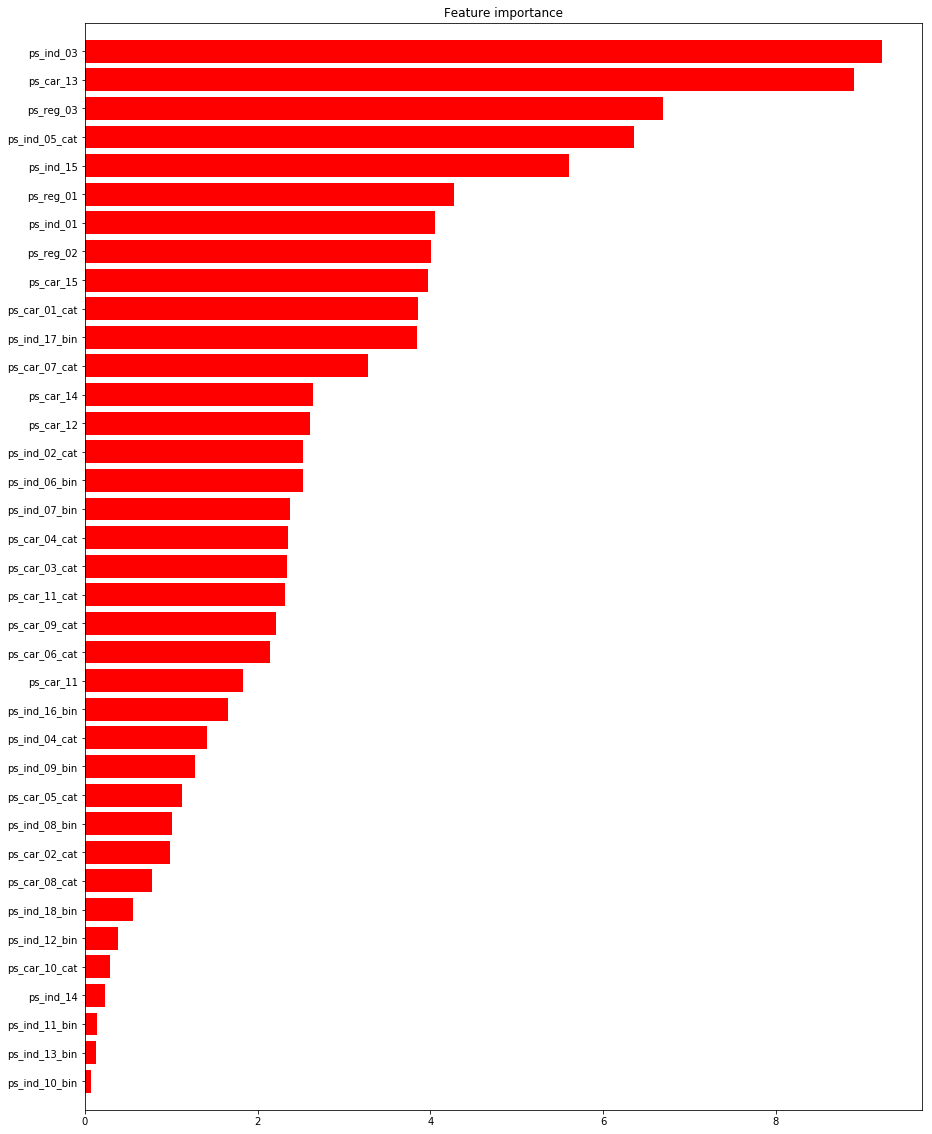

In [70]:
impList = list()
iterList = list()
for model in modelList:
    impList.append(model._feature_importance)
    print model.tree_count_
    iterList.append(model.tree_count_)
    
impCoeffs = np.array(impList).mean(axis = 0)
impDict = plotFeatureImportance(impCoeffs,X_train2.columns.tolist())
print np.array(iterList).mean()

In [63]:
2*np.array(scoreList).mean()-1

0.28222942415326813

params =  {'depth': 7, 'rate': 0.03, 'l2': 8, 'T': 1}, early stop, 5 folds

Реальный скор 0.277

In [66]:
pred = list()
print "Prediction"

for model in modelList:
    print model.tree_count_
    pred.append(model.predict_proba(test_pool)[:,1])

pr = np.array(pred).mean(axis = 0) 

print "Save result"
submit(pr,'submission10.csv')

Prediction
588
588
588
588
588
Save result


Скор 0.278. Удалось улучшить скор на 0,002

Глубина 7, l2 = 8, скор 0.273

In [30]:
model3 = CatBoostClassifier(verbose= True, iterations=400, thread_count=4, depth= 7, learning_rate= 0.03, l2_leaf_reg= 8)
model3.fit(X_train2, y_train)
pr = model3.predict_proba(test_pool)[:,1]
submit(pr,'submission8.csv')

Borders for float features generated
0:	learn 0.6483239377	total: 1.58s	remaining: 10m 30s
1:	learn 0.6076389814	total: 1.91s	remaining: 6m 19s
2:	learn 0.5701958496	total: 3.67s	remaining: 8m 5s
3:	learn 0.5360109303	total: 4.02s	remaining: 6m 37s
4:	learn 0.5044954491	total: 4.52s	remaining: 5m 57s
5:	learn 0.4756557812	total: 5.03s	remaining: 5m 30s
6:	learn 0.4489175269	total: 5.49s	remaining: 5m 8s
7:	learn 0.4247784292	total: 5.93s	remaining: 4m 50s
8:	learn 0.4027187964	total: 6.55s	remaining: 4m 44s
9:	learn 0.3824228844	total: 7.04s	remaining: 4m 34s
10:	learn 0.3639273562	total: 8.83s	remaining: 5m 12s
11:	learn 0.3470806381	total: 9.74s	remaining: 5m 15s
12:	learn 0.3315859943	total: 10.3s	remaining: 5m 6s
13:	learn 0.3174341873	total: 10.8s	remaining: 4m 58s
14:	learn 0.3045896476	total: 11.3s	remaining: 4m 50s
15:	learn 0.2927816186	total: 11.8s	remaining: 4m 43s
16:	learn 0.2819390322	total: 12.4s	remaining: 4m 39s
17:	learn 0.2719697339	total: 13s	remaining: 4m 35s
18:	l

151:	learn 0.1520988451	total: 1m 46s	remaining: 2m 53s
152:	learn 0.1520833966	total: 1m 47s	remaining: 2m 53s
153:	learn 0.152071067	total: 1m 49s	remaining: 2m 54s
154:	learn 0.1520602435	total: 1m 49s	remaining: 2m 53s
155:	learn 0.1520489333	total: 1m 50s	remaining: 2m 53s
156:	learn 0.1520412577	total: 1m 51s	remaining: 2m 52s
157:	learn 0.1520310393	total: 1m 52s	remaining: 2m 52s
158:	learn 0.1520220545	total: 1m 54s	remaining: 2m 53s
159:	learn 0.1520163877	total: 1m 55s	remaining: 2m 52s
160:	learn 0.1520049692	total: 1m 55s	remaining: 2m 51s
161:	learn 0.1519969663	total: 1m 57s	remaining: 2m 53s
162:	learn 0.1519862383	total: 1m 58s	remaining: 2m 52s
163:	learn 0.151977612	total: 1m 59s	remaining: 2m 51s
164:	learn 0.1519698946	total: 1m 59s	remaining: 2m 50s
165:	learn 0.1519584575	total: 2m 1s	remaining: 2m 51s
166:	learn 0.1519481936	total: 2m 1s	remaining: 2m 50s
167:	learn 0.1519405297	total: 2m 3s	remaining: 2m 50s
168:	learn 0.1519299718	total: 2m 4s	remaining: 2m 50

299:	learn 0.151093266	total: 3m 47s	remaining: 1m 15s
300:	learn 0.1510878274	total: 3m 48s	remaining: 1m 15s
301:	learn 0.1510840036	total: 3m 49s	remaining: 1m 14s
302:	learn 0.1510788404	total: 3m 50s	remaining: 1m 13s
303:	learn 0.1510745931	total: 3m 50s	remaining: 1m 12s
304:	learn 0.1510681678	total: 3m 51s	remaining: 1m 11s
305:	learn 0.1510611083	total: 3m 52s	remaining: 1m 11s
306:	learn 0.1510574422	total: 3m 52s	remaining: 1m 10s
307:	learn 0.1510520234	total: 3m 54s	remaining: 1m 9s
308:	learn 0.1510494325	total: 3m 54s	remaining: 1m 9s
309:	learn 0.1510410562	total: 3m 55s	remaining: 1m 8s
310:	learn 0.1510341952	total: 3m 56s	remaining: 1m 7s
311:	learn 0.1510250691	total: 3m 56s	remaining: 1m 6s
312:	learn 0.1510189267	total: 3m 57s	remaining: 1m 5s
313:	learn 0.1510139062	total: 3m 57s	remaining: 1m 5s
314:	learn 0.1510093811	total: 3m 58s	remaining: 1m 4s
315:	learn 0.151006021	total: 3m 58s	remaining: 1m 3s
316:	learn 0.1510002354	total: 3m 59s	remaining: 1m 2s
317:

Скор 0,275

In [35]:
model4 = CatBoostClassifier(verbose= True, iterations= 650, thread_count= 4, depth= 7,train_dir= '/tmp/porto/catboost/',
                            learning_rate= 0.05, l2_leaf_reg= 8)

prList = list()
for seed in range(0,5):
    model4.set_params(random_seed = seed)
    model4.fit(X_train2, y_train)
    prList.append(model4.predict_proba(test_pool)[:,1])

pr = np.array(prList).mean(axis = 0)    
submit(pr,'submission9.csv')

Borders for float features generated
0:	learn 0.6205928769	total: 212ms	remaining: 2m 17s
1:	learn 0.5572124389	total: 672ms	remaining: 3m 37s
2:	learn 0.5025033789	total: 1.06s	remaining: 3m 47s
3:	learn 0.4551390152	total: 1.48s	remaining: 3m 59s
4:	learn 0.4146882319	total: 1.93s	remaining: 4m 8s
5:	learn 0.3799440396	total: 2.37s	remaining: 4m 14s
6:	learn 0.3499582118	total: 2.78s	remaining: 4m 15s
7:	learn 0.3241838919	total: 3.2s	remaining: 4m 17s
8:	learn 0.3020555008	total: 3.61s	remaining: 4m 17s
9:	learn 0.2831359002	total: 3.93s	remaining: 4m 11s
10:	learn 0.2666360298	total: 4.35s	remaining: 4m 12s
11:	learn 0.2523928783	total: 4.75s	remaining: 4m 12s
12:	learn 0.2402297308	total: 5.07s	remaining: 4m 8s
13:	learn 0.2296929364	total: 5.26s	remaining: 3m 58s
14:	learn 0.2204127554	total: 5.64s	remaining: 3m 58s
15:	learn 0.212444237	total: 6.03s	remaining: 3m 58s
16:	learn 0.2054651054	total: 6.47s	remaining: 4m 1s
17:	learn 0.199463778	total: 6.9s	remaining: 4m 2s
18:	learn

153:	learn 0.1513896776	total: 1m 1s	remaining: 3m 18s
154:	learn 0.1513809936	total: 1m 2s	remaining: 3m 18s
155:	learn 0.1513730603	total: 1m 2s	remaining: 3m 17s
156:	learn 0.1513582487	total: 1m 2s	remaining: 3m 17s
157:	learn 0.1513513458	total: 1m 3s	remaining: 3m 16s
158:	learn 0.1513458069	total: 1m 3s	remaining: 3m 16s
159:	learn 0.1513361326	total: 1m 4s	remaining: 3m 16s
160:	learn 0.15133605	total: 1m 4s	remaining: 3m 15s
161:	learn 0.1513258839	total: 1m 4s	remaining: 3m 14s
162:	learn 0.1513164006	total: 1m 5s	remaining: 3m 14s
163:	learn 0.1513054794	total: 1m 5s	remaining: 3m 13s
164:	learn 0.1512978248	total: 1m 5s	remaining: 3m 13s
165:	learn 0.1512855622	total: 1m 6s	remaining: 3m 13s
166:	learn 0.151276423	total: 1m 6s	remaining: 3m 12s
167:	learn 0.1512680857	total: 1m 6s	remaining: 3m 12s
168:	learn 0.1512577128	total: 1m 7s	remaining: 3m 11s
169:	learn 0.1512576629	total: 1m 7s	remaining: 3m 10s
170:	learn 0.1512504199	total: 1m 8s	remaining: 3m 10s
171:	learn 0.

301:	learn 0.1501693994	total: 2m 4s	remaining: 2m 23s
302:	learn 0.1501635097	total: 2m 4s	remaining: 2m 23s
303:	learn 0.1501562457	total: 2m 5s	remaining: 2m 22s
304:	learn 0.1501402366	total: 2m 5s	remaining: 2m 22s
305:	learn 0.1501330997	total: 2m 6s	remaining: 2m 22s
306:	learn 0.1501263854	total: 2m 6s	remaining: 2m 21s
307:	learn 0.1501202551	total: 2m 7s	remaining: 2m 21s
308:	learn 0.1501080256	total: 2m 7s	remaining: 2m 20s
309:	learn 0.1501033826	total: 2m 8s	remaining: 2m 20s
310:	learn 0.1501002542	total: 2m 8s	remaining: 2m 20s
311:	learn 0.150094454	total: 2m 9s	remaining: 2m 19s
312:	learn 0.1500801115	total: 2m 9s	remaining: 2m 19s
313:	learn 0.1500730554	total: 2m 10s	remaining: 2m 19s
314:	learn 0.1500676042	total: 2m 10s	remaining: 2m 18s
315:	learn 0.150065451	total: 2m 11s	remaining: 2m 18s
316:	learn 0.150059509	total: 2m 11s	remaining: 2m 18s
317:	learn 0.1500555276	total: 2m 11s	remaining: 2m 17s
318:	learn 0.1500467291	total: 2m 12s	remaining: 2m 17s
319:	le

449:	learn 0.1492116918	total: 3m 23s	remaining: 1m 30s
450:	learn 0.1492061943	total: 3m 24s	remaining: 1m 30s
451:	learn 0.1491968924	total: 3m 24s	remaining: 1m 29s
452:	learn 0.1491906835	total: 3m 25s	remaining: 1m 29s
453:	learn 0.1491835385	total: 3m 25s	remaining: 1m 28s
454:	learn 0.149177822	total: 3m 26s	remaining: 1m 28s
455:	learn 0.1491679404	total: 3m 26s	remaining: 1m 28s
456:	learn 0.14915564	total: 3m 27s	remaining: 1m 27s
457:	learn 0.1491527804	total: 3m 27s	remaining: 1m 27s
458:	learn 0.1491457804	total: 3m 28s	remaining: 1m 26s
459:	learn 0.1491405493	total: 3m 29s	remaining: 1m 26s
460:	learn 0.1491315668	total: 3m 29s	remaining: 1m 25s
461:	learn 0.14912796	total: 3m 30s	remaining: 1m 25s
462:	learn 0.149120542	total: 3m 30s	remaining: 1m 25s
463:	learn 0.1491164501	total: 3m 31s	remaining: 1m 24s
464:	learn 0.1491079262	total: 3m 31s	remaining: 1m 24s
465:	learn 0.1491013237	total: 3m 32s	remaining: 1m 23s
466:	learn 0.149093701	total: 3m 32s	remaining: 1m 23s

599:	learn 0.1483515473	total: 4m 42s	remaining: 23.6s
600:	learn 0.1483460684	total: 4m 43s	remaining: 23.1s
601:	learn 0.1483420263	total: 4m 43s	remaining: 22.6s
602:	learn 0.1483399671	total: 4m 43s	remaining: 22.1s
603:	learn 0.1483364878	total: 4m 44s	remaining: 21.7s
604:	learn 0.1483300667	total: 4m 44s	remaining: 21.2s
605:	learn 0.1483231071	total: 4m 45s	remaining: 20.7s
606:	learn 0.1483182687	total: 4m 45s	remaining: 20.2s
607:	learn 0.1483148158	total: 4m 46s	remaining: 19.8s
608:	learn 0.1483100516	total: 4m 46s	remaining: 19.3s
609:	learn 0.1483030198	total: 4m 46s	remaining: 18.8s
610:	learn 0.1482999532	total: 4m 47s	remaining: 18.3s
611:	learn 0.1482922244	total: 4m 47s	remaining: 17.9s
612:	learn 0.1482881415	total: 4m 48s	remaining: 17.4s
613:	learn 0.1482852614	total: 4m 48s	remaining: 16.9s
614:	learn 0.1482802623	total: 4m 48s	remaining: 16.4s
615:	learn 0.1482705739	total: 4m 49s	remaining: 16s
616:	learn 0.1482648541	total: 4m 49s	remaining: 15.5s
617:	learn 0

101:	learn 0.1520202006	total: 52.5s	remaining: 4m 42s
102:	learn 0.1520027909	total: 53s	remaining: 4m 41s
103:	learn 0.1519856958	total: 53.6s	remaining: 4m 41s
104:	learn 0.1519758301	total: 54.2s	remaining: 4m 41s
105:	learn 0.1519606018	total: 54.7s	remaining: 4m 40s
106:	learn 0.1519434126	total: 55.2s	remaining: 4m 40s
107:	learn 0.1519328729	total: 55.8s	remaining: 4m 39s
108:	learn 0.1519229799	total: 56.2s	remaining: 4m 38s
109:	learn 0.1519081659	total: 56.6s	remaining: 4m 38s
110:	learn 0.1518930159	total: 57.1s	remaining: 4m 37s
111:	learn 0.1518754302	total: 57.6s	remaining: 4m 36s
112:	learn 0.151863277	total: 58s	remaining: 4m 35s
113:	learn 0.1518465743	total: 58.4s	remaining: 4m 34s
114:	learn 0.1518277206	total: 58.8s	remaining: 4m 33s
115:	learn 0.1518190921	total: 59.2s	remaining: 4m 32s
116:	learn 0.1518115025	total: 59.6s	remaining: 4m 31s
117:	learn 0.151798403	total: 60s	remaining: 4m 30s
118:	learn 0.1517856949	total: 1m	remaining: 4m 29s
119:	learn 0.15176352

250:	learn 0.1505227092	total: 2m 7s	remaining: 3m 22s
251:	learn 0.1505143194	total: 2m 7s	remaining: 3m 21s
252:	learn 0.1505057941	total: 2m 8s	remaining: 3m 20s
253:	learn 0.1504954027	total: 2m 8s	remaining: 3m 20s
254:	learn 0.1504877703	total: 2m 8s	remaining: 3m 19s
255:	learn 0.1504848277	total: 2m 9s	remaining: 3m 18s
256:	learn 0.1504782349	total: 2m 9s	remaining: 3m 18s
257:	learn 0.1504739843	total: 2m 10s	remaining: 3m 17s
258:	learn 0.150467744	total: 2m 10s	remaining: 3m 17s
259:	learn 0.1504594773	total: 2m 11s	remaining: 3m 16s
260:	learn 0.1504539866	total: 2m 11s	remaining: 3m 16s
261:	learn 0.1504455671	total: 2m 12s	remaining: 3m 16s
262:	learn 0.1504415661	total: 2m 12s	remaining: 3m 15s
263:	learn 0.1504290633	total: 2m 13s	remaining: 3m 15s
264:	learn 0.150421531	total: 2m 14s	remaining: 3m 14s
265:	learn 0.1504164412	total: 2m 14s	remaining: 3m 14s
266:	learn 0.1504116924	total: 2m 15s	remaining: 3m 13s
267:	learn 0.1504075602	total: 2m 15s	remaining: 3m 13s
2

547:	learn 0.1485050687	total: 4m 13s	remaining: 47.2s
548:	learn 0.1484988585	total: 4m 13s	remaining: 46.7s
549:	learn 0.1484909359	total: 4m 14s	remaining: 46.2s
550:	learn 0.148487195	total: 4m 14s	remaining: 45.8s
551:	learn 0.148483969	total: 4m 15s	remaining: 45.3s
552:	learn 0.1484812116	total: 4m 15s	remaining: 44.8s
553:	learn 0.1484758523	total: 4m 16s	remaining: 44.4s
554:	learn 0.1484696858	total: 4m 16s	remaining: 43.9s
555:	learn 0.1484629317	total: 4m 16s	remaining: 43.4s
556:	learn 0.1484576611	total: 4m 17s	remaining: 43s
557:	learn 0.1484530979	total: 4m 17s	remaining: 42.5s
558:	learn 0.1484482426	total: 4m 18s	remaining: 42s
559:	learn 0.1484417407	total: 4m 18s	remaining: 41.5s
560:	learn 0.1484385932	total: 4m 18s	remaining: 41.1s
561:	learn 0.1484372022	total: 4m 19s	remaining: 40.6s
562:	learn 0.1484329913	total: 4m 19s	remaining: 40.1s
563:	learn 0.1484245087	total: 4m 20s	remaining: 39.7s
564:	learn 0.1484147669	total: 4m 20s	remaining: 39.2s
565:	learn 0.148

48:	learn 0.1544067124	total: 19.1s	remaining: 3m 53s
49:	learn 0.1542334839	total: 19.5s	remaining: 3m 53s
50:	learn 0.1540779736	total: 19.9s	remaining: 3m 53s
51:	learn 0.1539507669	total: 20.3s	remaining: 3m 52s
52:	learn 0.1538339479	total: 20.7s	remaining: 3m 52s
53:	learn 0.1537252189	total: 21s	remaining: 3m 51s
54:	learn 0.153607131	total: 21.4s	remaining: 3m 51s
55:	learn 0.153512114	total: 21.8s	remaining: 3m 51s
56:	learn 0.1534234708	total: 22.2s	remaining: 3m 50s
57:	learn 0.1533319887	total: 22.6s	remaining: 3m 50s
58:	learn 0.1532530684	total: 23s	remaining: 3m 49s
59:	learn 0.1531951923	total: 23.3s	remaining: 3m 49s
60:	learn 0.1531415325	total: 23.6s	remaining: 3m 48s
61:	learn 0.1530817086	total: 24s	remaining: 3m 47s
62:	learn 0.1530201608	total: 24.4s	remaining: 3m 47s
63:	learn 0.1529648782	total: 24.8s	remaining: 3m 46s
64:	learn 0.1529096066	total: 25.2s	remaining: 3m 46s
65:	learn 0.1528550595	total: 25.6s	remaining: 3m 46s
66:	learn 0.1528181096	total: 25.8s	

199:	learn 0.1508506383	total: 1m 21s	remaining: 3m 2s
200:	learn 0.1508447219	total: 1m 21s	remaining: 3m 2s
201:	learn 0.1508432676	total: 1m 22s	remaining: 3m 2s
202:	learn 0.1508217235	total: 1m 22s	remaining: 3m 2s
203:	learn 0.1508164493	total: 1m 23s	remaining: 3m 1s
204:	learn 0.1508104454	total: 1m 23s	remaining: 3m 1s
205:	learn 0.1507991915	total: 1m 24s	remaining: 3m 1s
206:	learn 0.1507915727	total: 1m 24s	remaining: 3m
207:	learn 0.1507854497	total: 1m 24s	remaining: 3m
208:	learn 0.1507774612	total: 1m 25s	remaining: 3m
209:	learn 0.150769069	total: 1m 25s	remaining: 2m 59s
210:	learn 0.1507668852	total: 1m 26s	remaining: 2m 59s
211:	learn 0.1507567619	total: 1m 26s	remaining: 2m 59s
212:	learn 0.150749464	total: 1m 27s	remaining: 2m 58s
213:	learn 0.1507410193	total: 1m 27s	remaining: 2m 58s
214:	learn 0.1507275818	total: 1m 28s	remaining: 2m 58s
215:	learn 0.1507226796	total: 1m 28s	remaining: 2m 57s
216:	learn 0.150715224	total: 1m 28s	remaining: 2m 57s
217:	learn 0.1

347:	learn 0.149780258	total: 2m 25s	remaining: 2m 6s
348:	learn 0.1497724192	total: 2m 26s	remaining: 2m 6s
349:	learn 0.1497673527	total: 2m 26s	remaining: 2m 5s
350:	learn 0.1497602263	total: 2m 27s	remaining: 2m 5s
351:	learn 0.149746402	total: 2m 27s	remaining: 2m 5s
352:	learn 0.149740866	total: 2m 28s	remaining: 2m 4s
353:	learn 0.1497340826	total: 2m 28s	remaining: 2m 4s
354:	learn 0.1497228952	total: 2m 28s	remaining: 2m 3s
355:	learn 0.1497149298	total: 2m 29s	remaining: 2m 3s
356:	learn 0.1497064225	total: 2m 29s	remaining: 2m 2s
357:	learn 0.1496960991	total: 2m 30s	remaining: 2m 2s
358:	learn 0.1496902246	total: 2m 30s	remaining: 2m 2s
359:	learn 0.1496868157	total: 2m 30s	remaining: 2m 1s
360:	learn 0.14967953	total: 2m 31s	remaining: 2m 1s
361:	learn 0.1496728241	total: 2m 31s	remaining: 2m
362:	learn 0.1496674894	total: 2m 32s	remaining: 2m
363:	learn 0.1496599332	total: 2m 32s	remaining: 1m 59s
364:	learn 0.1496548187	total: 2m 33s	remaining: 1m 59s
365:	learn 0.149643

495:	learn 0.148809781	total: 3m 31s	remaining: 1m 5s
496:	learn 0.1488058463	total: 3m 31s	remaining: 1m 5s
497:	learn 0.1487990447	total: 3m 32s	remaining: 1m 4s
498:	learn 0.1487926015	total: 3m 32s	remaining: 1m 4s
499:	learn 0.1487865971	total: 3m 33s	remaining: 1m 3s
500:	learn 0.1487798504	total: 3m 33s	remaining: 1m 3s
501:	learn 0.1487742313	total: 3m 34s	remaining: 1m 3s
502:	learn 0.1487683576	total: 3m 34s	remaining: 1m 2s
503:	learn 0.1487627302	total: 3m 34s	remaining: 1m 2s
504:	learn 0.1487509252	total: 3m 35s	remaining: 1m 1s
505:	learn 0.1487464539	total: 3m 35s	remaining: 1m 1s
506:	learn 0.1487387308	total: 3m 36s	remaining: 1m 1s
507:	learn 0.1487328494	total: 3m 36s	remaining: 1m
508:	learn 0.1487269302	total: 3m 37s	remaining: 1m
509:	learn 0.1487195874	total: 3m 37s	remaining: 59.8s
510:	learn 0.1487115976	total: 3m 38s	remaining: 59.4s
511:	learn 0.1487058023	total: 3m 38s	remaining: 58.9s
512:	learn 0.1487017973	total: 3m 39s	remaining: 58.5s
513:	learn 0.1486

646:	learn 0.1479530994	total: 4m 40s	remaining: 1.3s
647:	learn 0.1479467164	total: 4m 40s	remaining: 866ms
648:	learn 0.1479423812	total: 4m 41s	remaining: 433ms
649:	learn 0.1479370021	total: 4m 41s	remaining: 0us
Borders for float features generated
0:	learn 0.6200194163	total: 427ms	remaining: 4m 37s
1:	learn 0.5567638873	total: 857ms	remaining: 4m 37s
2:	learn 0.5020042465	total: 1.38s	remaining: 4m 57s
3:	learn 0.4549806446	total: 1.77s	remaining: 4m 45s
4:	learn 0.4147719259	total: 2.29s	remaining: 4m 55s
5:	learn 0.3798357255	total: 2.69s	remaining: 4m 48s
6:	learn 0.3501102687	total: 3.05s	remaining: 4m 40s
7:	learn 0.3244935872	total: 3.46s	remaining: 4m 38s
8:	learn 0.3023106806	total: 3.92s	remaining: 4m 38s
9:	learn 0.2833722455	total: 4.34s	remaining: 4m 37s
10:	learn 0.2670207081	total: 4.72s	remaining: 4m 34s
11:	learn 0.2527885295	total: 5.12s	remaining: 4m 32s
12:	learn 0.2404621162	total: 5.61s	remaining: 4m 35s
13:	learn 0.2298618813	total: 6.07s	remaining: 4m 35s


148:	learn 0.1513463666	total: 1m 2s	remaining: 3m 28s
149:	learn 0.1513388312	total: 1m 2s	remaining: 3m 28s
150:	learn 0.1513294641	total: 1m 2s	remaining: 3m 27s
151:	learn 0.1513202289	total: 1m 3s	remaining: 3m 27s
152:	learn 0.1513122816	total: 1m 3s	remaining: 3m 27s
153:	learn 0.1513048736	total: 1m 4s	remaining: 3m 27s
154:	learn 0.1512960582	total: 1m 4s	remaining: 3m 26s
155:	learn 0.1512894052	total: 1m 5s	remaining: 3m 26s
156:	learn 0.1512822377	total: 1m 5s	remaining: 3m 25s
157:	learn 0.1512713271	total: 1m 5s	remaining: 3m 25s
158:	learn 0.1512549289	total: 1m 6s	remaining: 3m 24s
159:	learn 0.151245898	total: 1m 6s	remaining: 3m 24s
160:	learn 0.1512355266	total: 1m 7s	remaining: 3m 23s
161:	learn 0.1512185841	total: 1m 7s	remaining: 3m 23s
162:	learn 0.1512114014	total: 1m 7s	remaining: 3m 22s
163:	learn 0.1512063397	total: 1m 8s	remaining: 3m 22s
164:	learn 0.1511979206	total: 1m 8s	remaining: 3m 21s
165:	learn 0.151193268	total: 1m 9s	remaining: 3m 21s
166:	learn 0

296:	learn 0.1501699398	total: 2m 5s	remaining: 2m 28s
297:	learn 0.1501600409	total: 2m 5s	remaining: 2m 28s
298:	learn 0.1501514013	total: 2m 6s	remaining: 2m 28s
299:	learn 0.1501426288	total: 2m 6s	remaining: 2m 27s
300:	learn 0.1501334461	total: 2m 7s	remaining: 2m 27s
301:	learn 0.1501258067	total: 2m 7s	remaining: 2m 26s
302:	learn 0.1501164856	total: 2m 8s	remaining: 2m 26s
303:	learn 0.1501075553	total: 2m 8s	remaining: 2m 26s
304:	learn 0.1500994348	total: 2m 9s	remaining: 2m 25s
305:	learn 0.1500940478	total: 2m 9s	remaining: 2m 25s
306:	learn 0.1500873374	total: 2m 9s	remaining: 2m 25s
307:	learn 0.1500799583	total: 2m 10s	remaining: 2m 24s
308:	learn 0.1500747269	total: 2m 10s	remaining: 2m 24s
309:	learn 0.1500687604	total: 2m 11s	remaining: 2m 23s
310:	learn 0.1500615961	total: 2m 11s	remaining: 2m 23s
311:	learn 0.1500541628	total: 2m 11s	remaining: 2m 22s
312:	learn 0.1500444319	total: 2m 12s	remaining: 2m 22s
313:	learn 0.1500381861	total: 2m 12s	remaining: 2m 22s
314

444:	learn 0.1491870454	total: 3m 11s	remaining: 1m 28s
445:	learn 0.1491797572	total: 3m 11s	remaining: 1m 27s
446:	learn 0.149174594	total: 3m 12s	remaining: 1m 27s
447:	learn 0.1491626636	total: 3m 12s	remaining: 1m 26s
448:	learn 0.1491552188	total: 3m 13s	remaining: 1m 26s
449:	learn 0.1491484731	total: 3m 13s	remaining: 1m 26s
450:	learn 0.1491418544	total: 3m 14s	remaining: 1m 25s
451:	learn 0.1491358202	total: 3m 14s	remaining: 1m 25s
452:	learn 0.1491255534	total: 3m 15s	remaining: 1m 24s
453:	learn 0.1491231834	total: 3m 15s	remaining: 1m 24s
454:	learn 0.1491162812	total: 3m 16s	remaining: 1m 24s
455:	learn 0.1491111828	total: 3m 16s	remaining: 1m 23s
456:	learn 0.1491052325	total: 3m 16s	remaining: 1m 23s
457:	learn 0.149101048	total: 3m 17s	remaining: 1m 22s
458:	learn 0.1490983914	total: 3m 17s	remaining: 1m 22s
459:	learn 0.1490891724	total: 3m 18s	remaining: 1m 21s
460:	learn 0.1490860761	total: 3m 18s	remaining: 1m 21s
461:	learn 0.1490800928	total: 3m 19s	remaining: 1

594:	learn 0.1483159426	total: 4m 19s	remaining: 24s
595:	learn 0.1483111701	total: 4m 19s	remaining: 23.6s
596:	learn 0.1483033137	total: 4m 20s	remaining: 23.1s
597:	learn 0.1483014072	total: 4m 20s	remaining: 22.7s
598:	learn 0.1482961524	total: 4m 21s	remaining: 22.2s
599:	learn 0.1482905297	total: 4m 21s	remaining: 21.8s
600:	learn 0.1482890714	total: 4m 22s	remaining: 21.4s
601:	learn 0.1482841111	total: 4m 22s	remaining: 20.9s
602:	learn 0.1482801164	total: 4m 22s	remaining: 20.5s
603:	learn 0.1482762583	total: 4m 23s	remaining: 20.1s
604:	learn 0.1482714728	total: 4m 23s	remaining: 19.6s
605:	learn 0.1482657943	total: 4m 24s	remaining: 19.2s
606:	learn 0.1482611041	total: 4m 24s	remaining: 18.7s
607:	learn 0.1482534474	total: 4m 24s	remaining: 18.3s
608:	learn 0.1482447689	total: 4m 25s	remaining: 17.9s
609:	learn 0.1482363886	total: 4m 25s	remaining: 17.4s
610:	learn 0.148230797	total: 4m 26s	remaining: 17s
611:	learn 0.1482245314	total: 4m 26s	remaining: 16.5s
612:	learn 0.14

96:	learn 0.1520047613	total: 38.7s	remaining: 3m 40s
97:	learn 0.1519847697	total: 39.1s	remaining: 3m 40s
98:	learn 0.1519737974	total: 39.5s	remaining: 3m 39s
99:	learn 0.151959669	total: 39.9s	remaining: 3m 39s
100:	learn 0.1519316339	total: 40.3s	remaining: 3m 38s
101:	learn 0.1519106963	total: 40.7s	remaining: 3m 38s
102:	learn 0.151903128	total: 41s	remaining: 3m 37s
103:	learn 0.1518861504	total: 41.4s	remaining: 3m 37s
104:	learn 0.1518696877	total: 41.7s	remaining: 3m 36s
105:	learn 0.1518593764	total: 42.2s	remaining: 3m 36s
106:	learn 0.1518445871	total: 42.6s	remaining: 3m 36s
107:	learn 0.15182885	total: 43.1s	remaining: 3m 36s
108:	learn 0.1518091195	total: 43.5s	remaining: 3m 35s
109:	learn 0.151790753	total: 44s	remaining: 3m 35s
110:	learn 0.1517744853	total: 44.4s	remaining: 3m 35s
111:	learn 0.1517585199	total: 44.9s	remaining: 3m 35s
112:	learn 0.1517475367	total: 45.3s	remaining: 3m 35s
113:	learn 0.151734403	total: 45.7s	remaining: 3m 34s
114:	learn 0.1517175324	

393:	learn 0.1495093403	total: 2m 49s	remaining: 1m 50s
394:	learn 0.1495027464	total: 2m 49s	remaining: 1m 49s
395:	learn 0.1494947024	total: 2m 50s	remaining: 1m 49s
396:	learn 0.1494896404	total: 2m 50s	remaining: 1m 48s
397:	learn 0.1494790785	total: 2m 51s	remaining: 1m 48s
398:	learn 0.149474539	total: 2m 51s	remaining: 1m 48s
399:	learn 0.1494654767	total: 2m 52s	remaining: 1m 47s
400:	learn 0.1494554412	total: 2m 52s	remaining: 1m 47s
401:	learn 0.1494487525	total: 2m 53s	remaining: 1m 46s
402:	learn 0.1494428827	total: 2m 53s	remaining: 1m 46s
403:	learn 0.1494376452	total: 2m 53s	remaining: 1m 45s
404:	learn 0.1494260533	total: 2m 54s	remaining: 1m 45s
405:	learn 0.1494236916	total: 2m 54s	remaining: 1m 45s
406:	learn 0.1494211044	total: 2m 55s	remaining: 1m 44s
407:	learn 0.1494075744	total: 2m 55s	remaining: 1m 44s
408:	learn 0.1494018525	total: 2m 56s	remaining: 1m 43s
409:	learn 0.1493969009	total: 2m 56s	remaining: 1m 43s
410:	learn 0.1493911587	total: 2m 57s	remaining: 

542:	learn 0.1485528599	total: 3m 53s	remaining: 46s
543:	learn 0.1485484785	total: 3m 54s	remaining: 45.6s
544:	learn 0.1485430267	total: 3m 54s	remaining: 45.2s
545:	learn 0.1485387866	total: 3m 55s	remaining: 44.8s
546:	learn 0.148535691	total: 3m 55s	remaining: 44.3s
547:	learn 0.1485321881	total: 3m 55s	remaining: 43.9s
548:	learn 0.1485295935	total: 3m 56s	remaining: 43.5s
549:	learn 0.148522677	total: 3m 56s	remaining: 43.1s
550:	learn 0.1485151964	total: 3m 57s	remaining: 42.6s
551:	learn 0.1485097546	total: 3m 57s	remaining: 42.2s
552:	learn 0.148501942	total: 3m 58s	remaining: 41.8s
553:	learn 0.1484980653	total: 3m 58s	remaining: 41.3s
554:	learn 0.1484906732	total: 3m 58s	remaining: 40.9s
555:	learn 0.1484848149	total: 3m 59s	remaining: 40.5s
556:	learn 0.1484793382	total: 3m 59s	remaining: 40s
557:	learn 0.1484719867	total: 4m	remaining: 39.6s
558:	learn 0.1484628955	total: 4m	remaining: 39.2s
559:	learn 0.1484558559	total: 4m 1s	remaining: 38.8s
560:	learn 0.148452906	tot

In [37]:
model4 = CatBoostClassifier(verbose= True, iterations= 750, thread_count= 4, depth= 7,train_dir= '/tmp/porto/catboost/',
                            learning_rate= 0.05, l2_leaf_reg= 8)

prList = list()
for seed in range(0,5):
    model4.set_params(random_seed = seed)
    model4.fit(X_train2, y_train)
    prList.append(model4.predict_proba(test_pool)[:,1])

pr = np.array(prList).mean(axis = 0)    
submit(pr,'submission9.csv')

Borders for float features generated
0:	learn 0.6205928769	total: 252ms	remaining: 3m 8s
1:	learn 0.5572124389	total: 659ms	remaining: 4m 6s
2:	learn 0.5025033789	total: 1.07s	remaining: 4m 27s
3:	learn 0.4551390152	total: 1.58s	remaining: 4m 55s
4:	learn 0.4146882319	total: 2.06s	remaining: 5m 6s
5:	learn 0.3799440396	total: 2.49s	remaining: 5m 8s
6:	learn 0.3499582118	total: 2.92s	remaining: 5m 10s
7:	learn 0.3241838919	total: 3.41s	remaining: 5m 15s
8:	learn 0.3020555008	total: 3.9s	remaining: 5m 21s
9:	learn 0.2831359002	total: 4.26s	remaining: 5m 15s
10:	learn 0.2666360298	total: 4.74s	remaining: 5m 18s
11:	learn 0.2523928783	total: 5.22s	remaining: 5m 20s
12:	learn 0.2402297308	total: 5.55s	remaining: 5m 14s
13:	learn 0.2296929364	total: 5.76s	remaining: 5m 2s
14:	learn 0.2204127554	total: 6.23s	remaining: 5m 5s
15:	learn 0.212444237	total: 6.69s	remaining: 5m 6s
16:	learn 0.2054651054	total: 7.15s	remaining: 5m 8s
17:	learn 0.199463778	total: 7.55s	remaining: 5m 7s
18:	learn 0.1

153:	learn 0.1513896776	total: 1m 5s	remaining: 4m 13s
154:	learn 0.1513809936	total: 1m 5s	remaining: 4m 12s
155:	learn 0.1513730603	total: 1m 6s	remaining: 4m 12s
156:	learn 0.1513582487	total: 1m 6s	remaining: 4m 12s
157:	learn 0.1513513458	total: 1m 7s	remaining: 4m 11s
158:	learn 0.1513458069	total: 1m 7s	remaining: 4m 11s
159:	learn 0.1513361326	total: 1m 8s	remaining: 4m 11s
160:	learn 0.15133605	total: 1m 8s	remaining: 4m 10s
161:	learn 0.1513258839	total: 1m 9s	remaining: 4m 11s
162:	learn 0.1513164006	total: 1m 9s	remaining: 4m 11s
163:	learn 0.1513054794	total: 1m 10s	remaining: 4m 11s
164:	learn 0.1512978248	total: 1m 10s	remaining: 4m 11s
165:	learn 0.1512855622	total: 1m 11s	remaining: 4m 10s
166:	learn 0.151276423	total: 1m 11s	remaining: 4m 10s
167:	learn 0.1512680857	total: 1m 12s	remaining: 4m 10s
168:	learn 0.1512577128	total: 1m 12s	remaining: 4m 9s
169:	learn 0.1512576629	total: 1m 12s	remaining: 4m 8s
170:	learn 0.1512504199	total: 1m 13s	remaining: 4m 8s
171:	lea

302:	learn 0.1501635097	total: 2m 13s	remaining: 3m 16s
303:	learn 0.1501562457	total: 2m 13s	remaining: 3m 15s
304:	learn 0.1501402366	total: 2m 13s	remaining: 3m 15s
305:	learn 0.1501330997	total: 2m 14s	remaining: 3m 14s
306:	learn 0.1501263854	total: 2m 14s	remaining: 3m 14s
307:	learn 0.1501202551	total: 2m 15s	remaining: 3m 13s
308:	learn 0.1501080256	total: 2m 15s	remaining: 3m 13s
309:	learn 0.1501033826	total: 2m 15s	remaining: 3m 12s
310:	learn 0.1501002542	total: 2m 16s	remaining: 3m 12s
311:	learn 0.150094454	total: 2m 16s	remaining: 3m 11s
312:	learn 0.1500801115	total: 2m 17s	remaining: 3m 11s
313:	learn 0.1500730554	total: 2m 17s	remaining: 3m 10s
314:	learn 0.1500676042	total: 2m 17s	remaining: 3m 10s
315:	learn 0.150065451	total: 2m 18s	remaining: 3m 9s
316:	learn 0.150059509	total: 2m 18s	remaining: 3m 9s
317:	learn 0.1500555276	total: 2m 19s	remaining: 3m 8s
318:	learn 0.1500467291	total: 2m 19s	remaining: 3m 8s
319:	learn 0.1500410997	total: 2m 19s	remaining: 3m 8s


450:	learn 0.1492061943	total: 3m 15s	remaining: 2m 9s
451:	learn 0.1491968924	total: 3m 16s	remaining: 2m 9s
452:	learn 0.1491906835	total: 3m 16s	remaining: 2m 9s
453:	learn 0.1491835385	total: 3m 17s	remaining: 2m 8s
454:	learn 0.149177822	total: 3m 17s	remaining: 2m 8s
455:	learn 0.1491679404	total: 3m 18s	remaining: 2m 7s
456:	learn 0.14915564	total: 3m 18s	remaining: 2m 7s
457:	learn 0.1491527804	total: 3m 19s	remaining: 2m 6s
458:	learn 0.1491457804	total: 3m 19s	remaining: 2m 6s
459:	learn 0.1491405493	total: 3m 19s	remaining: 2m 6s
460:	learn 0.1491315668	total: 3m 20s	remaining: 2m 5s
461:	learn 0.14912796	total: 3m 20s	remaining: 2m 5s
462:	learn 0.149120542	total: 3m 21s	remaining: 2m 4s
463:	learn 0.1491164501	total: 3m 21s	remaining: 2m 4s
464:	learn 0.1491079262	total: 3m 21s	remaining: 2m 3s
465:	learn 0.1491013237	total: 3m 22s	remaining: 2m 3s
466:	learn 0.149093701	total: 3m 22s	remaining: 2m 2s
467:	learn 0.1490842944	total: 3m 23s	remaining: 2m 2s
468:	learn 0.1490

598:	learn 0.1483585523	total: 4m 17s	remaining: 1m 5s
599:	learn 0.1483515473	total: 4m 18s	remaining: 1m 4s
600:	learn 0.1483460684	total: 4m 18s	remaining: 1m 4s
601:	learn 0.1483420263	total: 4m 19s	remaining: 1m 3s
602:	learn 0.1483399671	total: 4m 19s	remaining: 1m 3s
603:	learn 0.1483364878	total: 4m 19s	remaining: 1m 2s
604:	learn 0.1483300667	total: 4m 20s	remaining: 1m 2s
605:	learn 0.1483231071	total: 4m 20s	remaining: 1m 1s
606:	learn 0.1483182687	total: 4m 21s	remaining: 1m 1s
607:	learn 0.1483148158	total: 4m 21s	remaining: 1m 1s
608:	learn 0.1483100516	total: 4m 22s	remaining: 1m
609:	learn 0.1483030198	total: 4m 22s	remaining: 1m
610:	learn 0.1482999532	total: 4m 22s	remaining: 59.8s
611:	learn 0.1482922244	total: 4m 23s	remaining: 59.4s
612:	learn 0.1482881415	total: 4m 23s	remaining: 59s
613:	learn 0.1482852614	total: 4m 24s	remaining: 58.5s
614:	learn 0.1482802623	total: 4m 24s	remaining: 58.1s
615:	learn 0.1482705739	total: 4m 25s	remaining: 57.7s
616:	learn 0.14826

749:	learn 0.1475253487	total: 5m 23s	remaining: 0us
Borders for float features generated
0:	learn 0.619884885	total: 397ms	remaining: 4m 57s
1:	learn 0.5565452718	total: 803ms	remaining: 5m
2:	learn 0.5024852143	total: 1s	remaining: 4m 9s
3:	learn 0.4556744731	total: 1.43s	remaining: 4m 26s
4:	learn 0.4153104255	total: 1.87s	remaining: 4m 38s
5:	learn 0.3805707425	total: 2.31s	remaining: 4m 46s
6:	learn 0.3505427207	total: 2.68s	remaining: 4m 44s
7:	learn 0.3247657673	total: 3.1s	remaining: 4m 48s
8:	learn 0.3024781767	total: 3.52s	remaining: 4m 49s
9:	learn 0.2835544099	total: 3.76s	remaining: 4m 38s
10:	learn 0.2671028826	total: 4.09s	remaining: 4m 34s
11:	learn 0.2528705614	total: 4.48s	remaining: 4m 35s
12:	learn 0.2403952332	total: 4.89s	remaining: 4m 37s
13:	learn 0.2297775435	total: 5.35s	remaining: 4m 41s
14:	learn 0.2205814939	total: 5.86s	remaining: 4m 47s
15:	learn 0.2124774578	total: 6.31s	remaining: 4m 49s
16:	learn 0.2054860812	total: 6.7s	remaining: 4m 49s
17:	learn 0.1

151:	learn 0.1513710474	total: 1m	remaining: 3m 58s
152:	learn 0.1513641137	total: 1m 1s	remaining: 3m 58s
153:	learn 0.1513561035	total: 1m 1s	remaining: 3m 57s
154:	learn 0.1513476625	total: 1m 1s	remaining: 3m 57s
155:	learn 0.1513398006	total: 1m 2s	remaining: 3m 57s
156:	learn 0.15132892	total: 1m 2s	remaining: 3m 57s
157:	learn 0.1513223652	total: 1m 3s	remaining: 3m 56s
158:	learn 0.151313554	total: 1m 3s	remaining: 3m 56s
159:	learn 0.1513064395	total: 1m 4s	remaining: 3m 56s
160:	learn 0.1512945225	total: 1m 4s	remaining: 3m 55s
161:	learn 0.1512860349	total: 1m 4s	remaining: 3m 55s
162:	learn 0.1512742667	total: 1m 5s	remaining: 3m 54s
163:	learn 0.1512731029	total: 1m 5s	remaining: 3m 53s
164:	learn 0.1512658826	total: 1m 5s	remaining: 3m 53s
165:	learn 0.1512640068	total: 1m 6s	remaining: 3m 52s
166:	learn 0.1512534339	total: 1m 6s	remaining: 3m 52s
167:	learn 0.1512487503	total: 1m 6s	remaining: 3m 51s
168:	learn 0.1512403894	total: 1m 7s	remaining: 3m 51s
169:	learn 0.151

299:	learn 0.1501553402	total: 2m	remaining: 3m
300:	learn 0.1501415249	total: 2m	remaining: 3m
301:	learn 0.1501312996	total: 2m 1s	remaining: 2m 59s
302:	learn 0.1501240785	total: 2m 1s	remaining: 2m 59s
303:	learn 0.1501140488	total: 2m 2s	remaining: 2m 59s
304:	learn 0.150106239	total: 2m 2s	remaining: 2m 58s
305:	learn 0.1500973953	total: 2m 2s	remaining: 2m 58s
306:	learn 0.1500862613	total: 2m 3s	remaining: 2m 58s
307:	learn 0.1500793288	total: 2m 3s	remaining: 2m 57s
308:	learn 0.1500724045	total: 2m 4s	remaining: 2m 57s
309:	learn 0.150067951	total: 2m 4s	remaining: 2m 56s
310:	learn 0.1500610192	total: 2m 5s	remaining: 2m 56s
311:	learn 0.1500539891	total: 2m 5s	remaining: 2m 56s
312:	learn 0.1500437731	total: 2m 5s	remaining: 2m 55s
313:	learn 0.1500388123	total: 2m 6s	remaining: 2m 55s
314:	learn 0.1500287713	total: 2m 6s	remaining: 2m 55s
315:	learn 0.1500222783	total: 2m 7s	remaining: 2m 54s
316:	learn 0.150013937	total: 2m 7s	remaining: 2m 54s
317:	learn 0.1500066507	tot

447:	learn 0.1491288058	total: 3m 2s	remaining: 2m 2s
448:	learn 0.1491216987	total: 3m 2s	remaining: 2m 2s
449:	learn 0.1491179058	total: 3m 3s	remaining: 2m 2s
450:	learn 0.1491143506	total: 3m 3s	remaining: 2m 1s
451:	learn 0.1491100378	total: 3m 3s	remaining: 2m 1s
452:	learn 0.1491010636	total: 3m 4s	remaining: 2m
453:	learn 0.1490940981	total: 3m 4s	remaining: 2m
454:	learn 0.1490875282	total: 3m 4s	remaining: 1m 59s
455:	learn 0.1490763336	total: 3m 5s	remaining: 1m 59s
456:	learn 0.1490663712	total: 3m 5s	remaining: 1m 59s
457:	learn 0.1490586903	total: 3m 6s	remaining: 1m 58s
458:	learn 0.1490529554	total: 3m 6s	remaining: 1m 58s
459:	learn 0.1490499767	total: 3m 6s	remaining: 1m 57s
460:	learn 0.1490444673	total: 3m 7s	remaining: 1m 57s
461:	learn 0.1490399387	total: 3m 7s	remaining: 1m 57s
462:	learn 0.1490314138	total: 3m 8s	remaining: 1m 56s
463:	learn 0.1490265561	total: 3m 8s	remaining: 1m 56s
464:	learn 0.1490221258	total: 3m 9s	remaining: 1m 55s
465:	learn 0.149016532	

595:	learn 0.1482234196	total: 4m 4s	remaining: 1m 3s
596:	learn 0.148210079	total: 4m 4s	remaining: 1m 2s
597:	learn 0.1482050611	total: 4m 4s	remaining: 1m 2s
598:	learn 0.1482006037	total: 4m 5s	remaining: 1m 1s
599:	learn 0.1481961408	total: 4m 5s	remaining: 1m 1s
600:	learn 0.1481899144	total: 4m 6s	remaining: 1m 1s
601:	learn 0.148187877	total: 4m 6s	remaining: 1m
602:	learn 0.1481847559	total: 4m 7s	remaining: 1m
603:	learn 0.1481772206	total: 4m 7s	remaining: 59.8s
604:	learn 0.1481683886	total: 4m 7s	remaining: 59.4s
605:	learn 0.1481622508	total: 4m 8s	remaining: 59s
606:	learn 0.1481561538	total: 4m 8s	remaining: 58.6s
607:	learn 0.1481498691	total: 4m 9s	remaining: 58.2s
608:	learn 0.1481416544	total: 4m 9s	remaining: 57.7s
609:	learn 0.1481309027	total: 4m 9s	remaining: 57.3s
610:	learn 0.1481240206	total: 4m 10s	remaining: 56.9s
611:	learn 0.1481184485	total: 4m 10s	remaining: 56.5s
612:	learn 0.1481096748	total: 4m 10s	remaining: 56.1s
613:	learn 0.1481038003	total: 4m 1

746:	learn 0.1474204185	total: 5m 5s	remaining: 1.23s
747:	learn 0.1474163175	total: 5m 6s	remaining: 818ms
748:	learn 0.1474143523	total: 5m 6s	remaining: 409ms
749:	learn 0.1474094748	total: 5m 6s	remaining: 0us
Borders for float features generated
0:	learn 0.6204461449	total: 336ms	remaining: 4m 11s
1:	learn 0.5570470594	total: 744ms	remaining: 4m 38s
2:	learn 0.5022949548	total: 1.19s	remaining: 4m 55s
3:	learn 0.4554740228	total: 1.64s	remaining: 5m 5s
4:	learn 0.4149756361	total: 2.03s	remaining: 5m 2s
5:	learn 0.3800359701	total: 2.42s	remaining: 4m 59s
6:	learn 0.350101801	total: 2.81s	remaining: 4m 58s
7:	learn 0.3244499529	total: 3.22s	remaining: 4m 58s
8:	learn 0.3022485873	total: 3.62s	remaining: 4m 58s
9:	learn 0.2832208536	total: 4.01s	remaining: 4m 56s
10:	learn 0.2668191737	total: 4.39s	remaining: 4m 54s
11:	learn 0.2527134317	total: 4.64s	remaining: 4m 45s
12:	learn 0.2404727665	total: 5.04s	remaining: 4m 45s
13:	learn 0.2297266898	total: 5.44s	remaining: 4m 46s
14:	le

148:	learn 0.1513247437	total: 58.5s	remaining: 3m 55s
149:	learn 0.1513144047	total: 58.9s	remaining: 3m 55s
150:	learn 0.1512987469	total: 59.2s	remaining: 3m 54s
151:	learn 0.1512904519	total: 59.6s	remaining: 3m 54s
152:	learn 0.1512780203	total: 1m	remaining: 3m 54s
153:	learn 0.1512682086	total: 1m	remaining: 3m 53s
154:	learn 0.1512533915	total: 1m	remaining: 3m 53s
155:	learn 0.1512450679	total: 1m 1s	remaining: 3m 52s
156:	learn 0.1512362827	total: 1m 1s	remaining: 3m 52s
157:	learn 0.1512233333	total: 1m 1s	remaining: 3m 52s
158:	learn 0.1512091245	total: 1m 2s	remaining: 3m 51s
159:	learn 0.1512012711	total: 1m 2s	remaining: 3m 51s
160:	learn 0.1511928219	total: 1m 3s	remaining: 3m 50s
161:	learn 0.1511818265	total: 1m 3s	remaining: 3m 50s
162:	learn 0.1511690796	total: 1m 3s	remaining: 3m 50s
163:	learn 0.1511587152	total: 1m 4s	remaining: 3m 49s
164:	learn 0.1511527607	total: 1m 4s	remaining: 3m 49s
165:	learn 0.1511421094	total: 1m 5s	remaining: 3m 49s
166:	learn 0.151134

296:	learn 0.150137364	total: 1m 57s	remaining: 2m 58s
297:	learn 0.1501311517	total: 1m 57s	remaining: 2m 58s
298:	learn 0.1501208938	total: 1m 58s	remaining: 2m 58s
299:	learn 0.1501151259	total: 1m 58s	remaining: 2m 57s
300:	learn 0.1501069037	total: 1m 58s	remaining: 2m 57s
301:	learn 0.1501015644	total: 1m 59s	remaining: 2m 57s
302:	learn 0.1500968784	total: 1m 59s	remaining: 2m 56s
303:	learn 0.1500924696	total: 2m	remaining: 2m 56s
304:	learn 0.1500836401	total: 2m	remaining: 2m 55s
305:	learn 0.150077401	total: 2m	remaining: 2m 55s
306:	learn 0.1500731764	total: 2m 1s	remaining: 2m 55s
307:	learn 0.1500658625	total: 2m 1s	remaining: 2m 54s
308:	learn 0.1500593689	total: 2m 2s	remaining: 2m 54s
309:	learn 0.1500491533	total: 2m 2s	remaining: 2m 54s
310:	learn 0.1500361594	total: 2m 3s	remaining: 2m 53s
311:	learn 0.150026907	total: 2m 3s	remaining: 2m 53s
312:	learn 0.1500224217	total: 2m 3s	remaining: 2m 53s
313:	learn 0.150019755	total: 2m 4s	remaining: 2m 52s
314:	learn 0.150

444:	learn 0.1491019078	total: 2m 56s	remaining: 2m 1s
445:	learn 0.1490949093	total: 2m 57s	remaining: 2m
446:	learn 0.1490887759	total: 2m 57s	remaining: 2m
447:	learn 0.1490840639	total: 2m 58s	remaining: 2m
448:	learn 0.1490778285	total: 2m 58s	remaining: 1m 59s
449:	learn 0.1490708103	total: 2m 58s	remaining: 1m 59s
450:	learn 0.1490643933	total: 2m 59s	remaining: 1m 58s
451:	learn 0.149060311	total: 2m 59s	remaining: 1m 58s
452:	learn 0.1490522585	total: 2m 59s	remaining: 1m 57s
453:	learn 0.1490462954	total: 3m	remaining: 1m 57s
454:	learn 0.1490376676	total: 3m	remaining: 1m 57s
455:	learn 0.149033257	total: 3m 1s	remaining: 1m 56s
456:	learn 0.1490302768	total: 3m 1s	remaining: 1m 56s
457:	learn 0.1490222211	total: 3m 2s	remaining: 1m 56s
458:	learn 0.1490153831	total: 3m 2s	remaining: 1m 55s
459:	learn 0.1490118214	total: 3m 2s	remaining: 1m 55s
460:	learn 0.1490041408	total: 3m 3s	remaining: 1m 54s
461:	learn 0.1489972819	total: 3m 3s	remaining: 1m 54s
462:	learn 0.148992085

592:	learn 0.1482314798	total: 3m 56s	remaining: 1m 2s
593:	learn 0.1482186157	total: 3m 56s	remaining: 1m 2s
594:	learn 0.1482101022	total: 3m 57s	remaining: 1m 1s
595:	learn 0.1482048668	total: 3m 57s	remaining: 1m 1s
596:	learn 0.1482007845	total: 3m 57s	remaining: 1m
597:	learn 0.1481943383	total: 3m 58s	remaining: 1m
598:	learn 0.1481908162	total: 3m 58s	remaining: 1m
599:	learn 0.1481840128	total: 3m 58s	remaining: 59.7s
600:	learn 0.1481791075	total: 3m 59s	remaining: 59.4s
601:	learn 0.1481734448	total: 3m 59s	remaining: 59s
602:	learn 0.1481704342	total: 4m	remaining: 58.6s
603:	learn 0.1481644964	total: 4m	remaining: 58.2s
604:	learn 0.1481617712	total: 4m 1s	remaining: 57.8s
605:	learn 0.1481543826	total: 4m 1s	remaining: 57.4s
606:	learn 0.1481498233	total: 4m 1s	remaining: 57s
607:	learn 0.1481427168	total: 4m 2s	remaining: 56.6s
608:	learn 0.148137507	total: 4m 2s	remaining: 56.2s
609:	learn 0.1481317142	total: 4m 3s	remaining: 55.8s
610:	learn 0.1481249885	total: 4m 3s	r

743:	learn 0.1474169507	total: 4m 58s	remaining: 2.4s
744:	learn 0.1474122193	total: 4m 58s	remaining: 2s
745:	learn 0.1474066447	total: 4m 59s	remaining: 1.6s
746:	learn 0.147402584	total: 4m 59s	remaining: 1.2s
747:	learn 0.1473976034	total: 4m 59s	remaining: 802ms
748:	learn 0.1473926859	total: 5m	remaining: 401ms
749:	learn 0.1473872701	total: 5m	remaining: 0us
Borders for float features generated
0:	learn 0.6200194163	total: 364ms	remaining: 4m 32s
1:	learn 0.5567638873	total: 793ms	remaining: 4m 56s
2:	learn 0.5020042465	total: 1.21s	remaining: 5m 1s
3:	learn 0.4549806446	total: 1.58s	remaining: 4m 54s
4:	learn 0.4147719259	total: 2.01s	remaining: 4m 59s
5:	learn 0.3798357255	total: 2.38s	remaining: 4m 55s
6:	learn 0.3501102687	total: 2.75s	remaining: 4m 52s
7:	learn 0.3244935872	total: 3.16s	remaining: 4m 53s
8:	learn 0.3023106806	total: 3.55s	remaining: 4m 52s
9:	learn 0.2833722455	total: 3.92s	remaining: 4m 50s
10:	learn 0.2670207081	total: 4.3s	remaining: 4m 48s
11:	learn 0.2

145:	learn 0.1513802383	total: 57.7s	remaining: 3m 58s
146:	learn 0.1513671949	total: 58s	remaining: 3m 58s
147:	learn 0.1513609345	total: 58.4s	remaining: 3m 57s
148:	learn 0.1513463666	total: 58.8s	remaining: 3m 57s
149:	learn 0.1513388312	total: 59.2s	remaining: 3m 56s
150:	learn 0.1513294641	total: 59.6s	remaining: 3m 56s
151:	learn 0.1513202289	total: 59.9s	remaining: 3m 55s
152:	learn 0.1513122816	total: 1m	remaining: 3m 55s
153:	learn 0.1513048736	total: 1m	remaining: 3m 55s
154:	learn 0.1512960582	total: 1m 1s	remaining: 3m 54s
155:	learn 0.1512894052	total: 1m 1s	remaining: 3m 54s
156:	learn 0.1512822377	total: 1m 1s	remaining: 3m 53s
157:	learn 0.1512713271	total: 1m 2s	remaining: 3m 53s
158:	learn 0.1512549289	total: 1m 2s	remaining: 3m 52s
159:	learn 0.151245898	total: 1m 3s	remaining: 3m 52s
160:	learn 0.1512355266	total: 1m 3s	remaining: 3m 51s
161:	learn 0.1512185841	total: 1m 3s	remaining: 3m 51s
162:	learn 0.1512114014	total: 1m 4s	remaining: 3m 51s
163:	learn 0.151206

293:	learn 0.1501919444	total: 1m 56s	remaining: 3m
294:	learn 0.1501820874	total: 1m 56s	remaining: 3m
295:	learn 0.1501739268	total: 1m 57s	remaining: 2m 59s
296:	learn 0.1501699398	total: 1m 57s	remaining: 2m 59s
297:	learn 0.1501600409	total: 1m 57s	remaining: 2m 58s
298:	learn 0.1501514013	total: 1m 58s	remaining: 2m 58s
299:	learn 0.1501426288	total: 1m 58s	remaining: 2m 58s
300:	learn 0.1501334461	total: 1m 59s	remaining: 2m 57s
301:	learn 0.1501258067	total: 1m 59s	remaining: 2m 57s
302:	learn 0.1501164856	total: 1m 59s	remaining: 2m 56s
303:	learn 0.1501075553	total: 2m	remaining: 2m 56s
304:	learn 0.1500994348	total: 2m	remaining: 2m 56s
305:	learn 0.1500940478	total: 2m 1s	remaining: 2m 55s
306:	learn 0.1500873374	total: 2m 1s	remaining: 2m 55s
307:	learn 0.1500799583	total: 2m 1s	remaining: 2m 54s
308:	learn 0.1500747269	total: 2m 2s	remaining: 2m 54s
309:	learn 0.1500687604	total: 2m 2s	remaining: 2m 54s
310:	learn 0.1500615961	total: 2m 3s	remaining: 2m 53s
311:	learn 0.1

441:	learn 0.1492048113	total: 2m 56s	remaining: 2m 2s
442:	learn 0.1492033528	total: 2m 56s	remaining: 2m 2s
443:	learn 0.1491925992	total: 2m 57s	remaining: 2m 2s
444:	learn 0.1491870454	total: 2m 57s	remaining: 2m 1s
445:	learn 0.1491797572	total: 2m 57s	remaining: 2m 1s
446:	learn 0.149174594	total: 2m 58s	remaining: 2m
447:	learn 0.1491626636	total: 2m 58s	remaining: 2m
448:	learn 0.1491552188	total: 2m 59s	remaining: 2m
449:	learn 0.1491484731	total: 2m 59s	remaining: 1m 59s
450:	learn 0.1491418544	total: 2m 59s	remaining: 1m 59s
451:	learn 0.1491358202	total: 3m	remaining: 1m 58s
452:	learn 0.1491255534	total: 3m	remaining: 1m 58s
453:	learn 0.1491231834	total: 3m 1s	remaining: 1m 58s
454:	learn 0.1491162812	total: 3m 1s	remaining: 1m 57s
455:	learn 0.1491111828	total: 3m 1s	remaining: 1m 57s
456:	learn 0.1491052325	total: 3m 2s	remaining: 1m 56s
457:	learn 0.149101048	total: 3m 2s	remaining: 1m 56s
458:	learn 0.1490983914	total: 3m 3s	remaining: 1m 56s
459:	learn 0.1490891724	t

589:	learn 0.1483413613	total: 3m 56s	remaining: 1m 4s
590:	learn 0.1483339645	total: 3m 56s	remaining: 1m 3s
591:	learn 0.1483273467	total: 3m 57s	remaining: 1m 3s
592:	learn 0.1483239785	total: 3m 57s	remaining: 1m 2s
593:	learn 0.148318925	total: 3m 58s	remaining: 1m 2s
594:	learn 0.1483159426	total: 3m 58s	remaining: 1m 2s
595:	learn 0.1483111701	total: 3m 59s	remaining: 1m 1s
596:	learn 0.1483033137	total: 3m 59s	remaining: 1m 1s
597:	learn 0.1483014072	total: 3m 59s	remaining: 1m
598:	learn 0.1482961524	total: 4m	remaining: 1m
599:	learn 0.1482905297	total: 4m	remaining: 1m
600:	learn 0.1482890714	total: 4m 1s	remaining: 59.8s
601:	learn 0.1482841111	total: 4m 1s	remaining: 59.4s
602:	learn 0.1482801164	total: 4m 2s	remaining: 59s
603:	learn 0.1482762583	total: 4m 2s	remaining: 58.6s
604:	learn 0.1482714728	total: 4m 2s	remaining: 58.2s
605:	learn 0.1482657943	total: 4m 3s	remaining: 57.8s
606:	learn 0.1482611041	total: 4m 3s	remaining: 57.4s
607:	learn 0.1482534474	total: 4m 3s	

740:	learn 0.1475531031	total: 4m 57s	remaining: 3.61s
741:	learn 0.1475485774	total: 4m 57s	remaining: 3.21s
742:	learn 0.1475443461	total: 4m 58s	remaining: 2.81s
743:	learn 0.1475374502	total: 4m 58s	remaining: 2.41s
744:	learn 0.1475339662	total: 4m 59s	remaining: 2.01s
745:	learn 0.1475321951	total: 4m 59s	remaining: 1.61s
746:	learn 0.1475220389	total: 5m	remaining: 1.21s
747:	learn 0.1475142485	total: 5m	remaining: 804ms
748:	learn 0.1475094758	total: 5m	remaining: 402ms
749:	learn 0.147504869	total: 5m 1s	remaining: 0us
Borders for float features generated
0:	learn 0.6196928592	total: 374ms	remaining: 4m 39s
1:	learn 0.5562922506	total: 767ms	remaining: 4m 46s
2:	learn 0.5017722169	total: 1.15s	remaining: 4m 47s
3:	learn 0.454827117	total: 1.55s	remaining: 4m 48s
4:	learn 0.4145224649	total: 1.92s	remaining: 4m 45s
5:	learn 0.3797420282	total: 2.33s	remaining: 4m 48s
6:	learn 0.3498116212	total: 2.75s	remaining: 4m 51s
7:	learn 0.3240047031	total: 3.14s	remaining: 4m 51s
8:	lea

290:	learn 0.150186955	total: 1m 55s	remaining: 3m 1s
291:	learn 0.1501807584	total: 1m 55s	remaining: 3m 1s
292:	learn 0.1501765575	total: 1m 55s	remaining: 3m
293:	learn 0.1501720727	total: 1m 56s	remaining: 3m
294:	learn 0.1501633958	total: 1m 56s	remaining: 2m 59s
295:	learn 0.1501558793	total: 1m 56s	remaining: 2m 59s
296:	learn 0.1501514789	total: 1m 57s	remaining: 2m 58s
297:	learn 0.1501449384	total: 1m 57s	remaining: 2m 58s
298:	learn 0.1501435493	total: 1m 58s	remaining: 2m 58s
299:	learn 0.1501361033	total: 1m 58s	remaining: 2m 57s
300:	learn 0.1501278507	total: 1m 58s	remaining: 2m 57s
301:	learn 0.1501220281	total: 1m 59s	remaining: 2m 56s
302:	learn 0.1501149906	total: 1m 59s	remaining: 2m 56s
303:	learn 0.1501119333	total: 2m	remaining: 2m 56s
304:	learn 0.1501021785	total: 2m	remaining: 2m 55s
305:	learn 0.1500982077	total: 2m	remaining: 2m 55s
306:	learn 0.1500924622	total: 2m 1s	remaining: 2m 55s
307:	learn 0.1500863681	total: 2m 1s	remaining: 2m 54s
308:	learn 0.1500

438:	learn 0.1492012378	total: 2m 55s	remaining: 2m 4s
439:	learn 0.1491954137	total: 2m 55s	remaining: 2m 3s
440:	learn 0.1491849888	total: 2m 56s	remaining: 2m 3s
441:	learn 0.1491730214	total: 2m 56s	remaining: 2m 2s
442:	learn 0.149165094	total: 2m 56s	remaining: 2m 2s
443:	learn 0.1491600429	total: 2m 57s	remaining: 2m 2s
444:	learn 0.1491575082	total: 2m 57s	remaining: 2m 1s
445:	learn 0.1491514218	total: 2m 58s	remaining: 2m 1s
446:	learn 0.1491472955	total: 2m 58s	remaining: 2m
447:	learn 0.1491379355	total: 2m 58s	remaining: 2m
448:	learn 0.1491326268	total: 2m 59s	remaining: 2m
449:	learn 0.1491272392	total: 2m 59s	remaining: 1m 59s
450:	learn 0.1491205031	total: 3m	remaining: 1m 59s
451:	learn 0.1491146937	total: 3m	remaining: 1m 59s
452:	learn 0.1491073676	total: 3m	remaining: 1m 58s
453:	learn 0.1491010592	total: 3m 1s	remaining: 1m 58s
454:	learn 0.1490972538	total: 3m 1s	remaining: 1m 57s
455:	learn 0.149090183	total: 3m 2s	remaining: 1m 57s
456:	learn 0.1490867573	total

586:	learn 0.148320721	total: 3m 55s	remaining: 1m 5s
587:	learn 0.1483152339	total: 3m 55s	remaining: 1m 5s
588:	learn 0.1483097161	total: 3m 56s	remaining: 1m 4s
589:	learn 0.1483038368	total: 3m 56s	remaining: 1m 4s
590:	learn 0.1482982402	total: 3m 57s	remaining: 1m 3s
591:	learn 0.1482935926	total: 3m 57s	remaining: 1m 3s
592:	learn 0.1482863995	total: 3m 57s	remaining: 1m 2s
593:	learn 0.1482807457	total: 3m 58s	remaining: 1m 2s
594:	learn 0.1482726102	total: 3m 58s	remaining: 1m 2s
595:	learn 0.1482696114	total: 3m 59s	remaining: 1m 1s
596:	learn 0.1482642353	total: 3m 59s	remaining: 1m 1s
597:	learn 0.1482545815	total: 3m 59s	remaining: 1m
598:	learn 0.1482467674	total: 4m	remaining: 1m
599:	learn 0.1482414103	total: 4m	remaining: 1m
600:	learn 0.1482369962	total: 4m 1s	remaining: 59.8s
601:	learn 0.148233886	total: 4m 1s	remaining: 59.4s
602:	learn 0.1482270913	total: 4m 1s	remaining: 59s
603:	learn 0.1482239429	total: 4m 2s	remaining: 58.6s
604:	learn 0.1482189882	total: 4m 2

737:	learn 0.147465575	total: 4m 57s	remaining: 4.83s
738:	learn 0.1474624854	total: 4m 57s	remaining: 4.43s
739:	learn 0.1474598522	total: 4m 58s	remaining: 4.03s
740:	learn 0.1474541984	total: 4m 58s	remaining: 3.62s
741:	learn 0.1474508224	total: 4m 58s	remaining: 3.22s
742:	learn 0.1474484369	total: 4m 59s	remaining: 2.82s
743:	learn 0.1474458196	total: 4m 59s	remaining: 2.42s
744:	learn 0.1474413865	total: 5m	remaining: 2.01s
745:	learn 0.1474397292	total: 5m	remaining: 1.61s
746:	learn 0.1474317662	total: 5m	remaining: 1.21s
747:	learn 0.1474288184	total: 5m 1s	remaining: 806ms
748:	learn 0.1474229935	total: 5m 1s	remaining: 403ms
749:	learn 0.1474210608	total: 5m 2s	remaining: 0us


Скор 0.280

### Отрежу все фичи со значимостью меньше 1

In [95]:
newFeatures = [k for (k,v) in impDict.items() if v >1]
[modelList2, scoreList] = trainCatBoost(X_train.loc[:,newFeatures],y_train)

<type 'exceptions.Exception'>
Tree amount is  459  ROC_AUC is 0.632318769754
Tree amount is  494  ROC_AUC is 0.63231991074
Tree amount is  514  ROC_AUC is 0.642868480394
Tree amount is  494  ROC_AUC is 0.642319545946
Tree amount is  726  ROC_AUC is 0.642444600204
Tree amount is  691  ROC_AUC is 0.644752603466
Tree amount is  566  ROC_AUC is 0.644872691261
Tree amount is  470  ROC_AUC is 0.642714230003
Tree amount is  472  ROC_AUC is 0.63720930857
Tree amount is  508  ROC_AUC is 0.648771138817


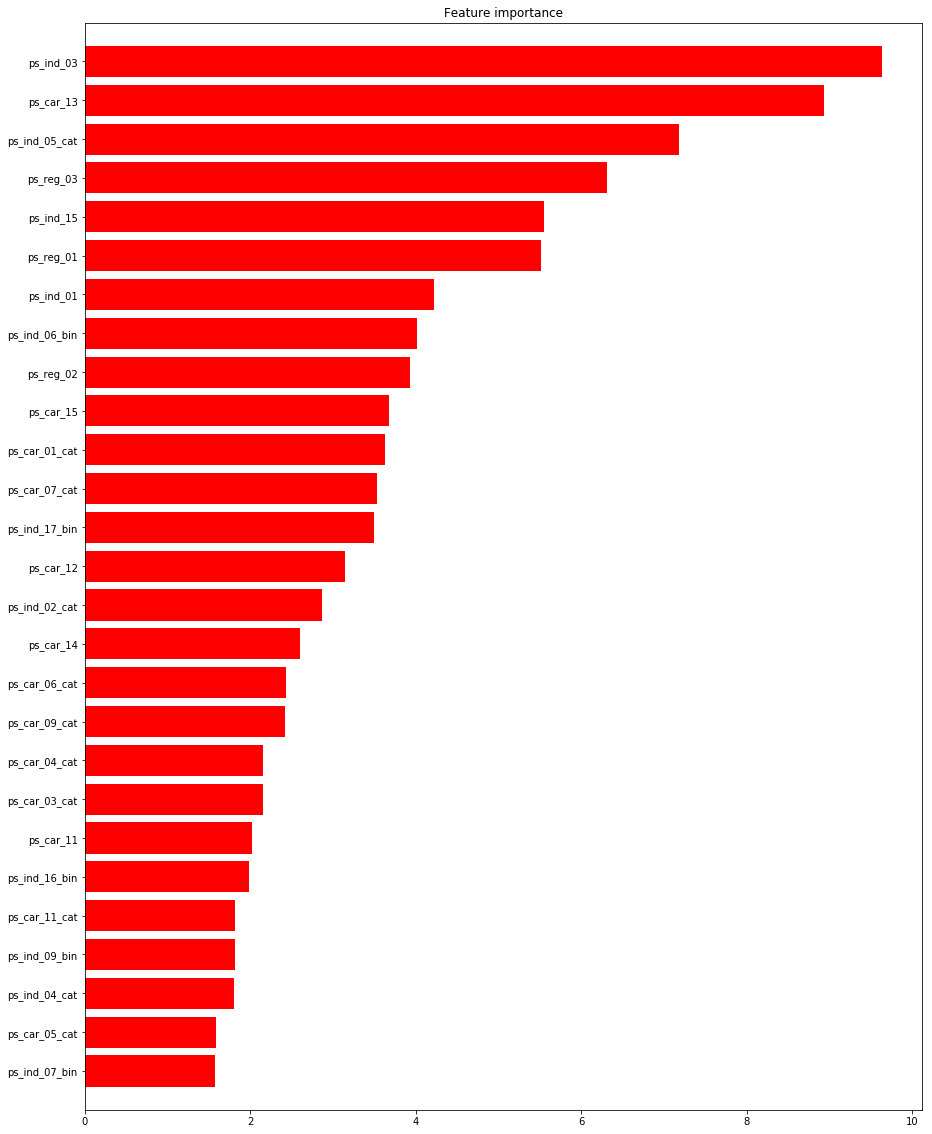

In [96]:
impList = list()
for model in modelList2:
    impList.append(model._feature_importance)
    
impCoeffs = np.array(impList).mean(axis = 0)
impDict = plotFeatureImportance(impCoeffs,X_train.loc[:,newFeatures].columns.tolist())

In [98]:
pred = list()
print "Prediction"
for model in modelList2:
    pred.append(model.predict_proba(test_pool)[:,1])

pr = np.array(pred).mean(axis = 0) 

print "Save result"
submit(pr,'submission6.csv')

Prediction
Save result


In [100]:
scoreArr = np.array(scoreList)

In [105]:
2*scoreArr.mean()-1

0.28211825583098449

In [106]:
scoreArr.std()

0.0051455838560032531

Скор упал до 0,011. Возможно, дело было в баге с random_seed

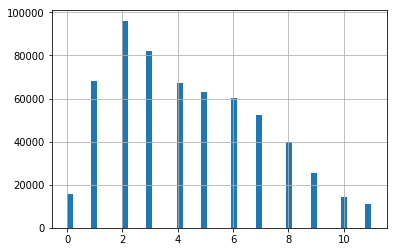

In [67]:
X_train.loc[:,'ps_ind_03'].hist(bins = 50)

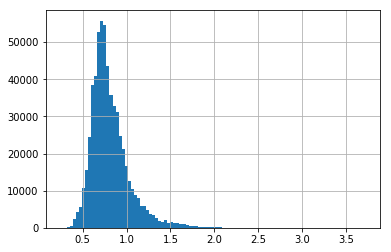

In [69]:
X_train.loc[:,'ps_car_13'].hist(bins = 100)

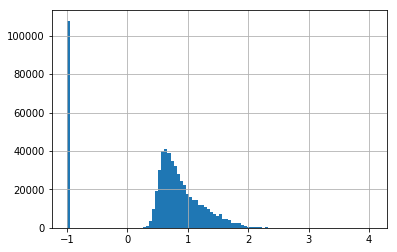

In [70]:
X_train.loc[:,'ps_reg_03'].hist(bins = 100)

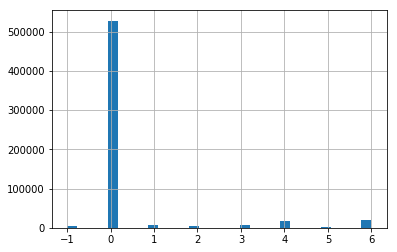

In [86]:
X_train.loc[:,'ps_ind_05_cat'].hist(bins = 30)

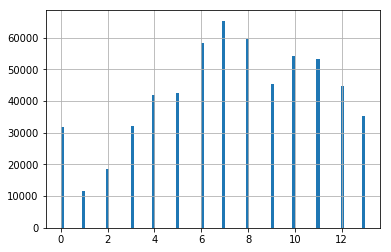

In [88]:
X_train.loc[:,'ps_ind_15'].hist(bins = 100)

In [11]:
2*0.6439298847-1

0.2878597694